In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import json
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from scipy.stats import norm
import re
from ipywidgets import interact, SelectionSlider, Dropdown, FloatSlider,fixed


# Predicting H-to-L Mode Back-Transitions in Tokamak Plasma Dynamics: Visualisation of data:
In a tokamak, plasma exists in different confinement modes, each corresponding to a specific state of plasma stability and energy retention. The two primary modes are Low (L) mode, characterized by lower confinement and heat retention, and High (H) mode, which exhibits enhanced confinement and better heat retention. Typically, plasma starts in L mode and may transition to H mode. However, in this analysis, we will focus on the back-transition, where plasma shifts from H mode back to L mode.

To begin, we aim to understand the underlying physics of these transitions. Our approach will involve:
1. Describing the recurrent features observed in experimental data.
2. Visualizing the distributions of key features over time, examining how they evolve during the transition. For this purpose we will employ histograms and boxplots. 
3. We will further investigate a key feature: Halpha13. To gain a better understanding we will also compute its Fast Fourier Transform
4. We will finally explore electron temperature and Density vs Radial Position

Next, we will explore the composition of the dataset:
* We will identify the key features present in the data.
* We will investigate possible feature combinations across different experiments.
* We will determine which feature combinations occur most frequently.
* We will assess the percentage of missing values (NaNs) for each feature.
* We will analyze the variance within each feature.
* We will investigate correlation between features and perform PCA analysis 
  
This exploration will provide foundational insights into the dataset, guiding further analysis steps in understanding the back-transition from H mode to L mode. The final conclusion of this notebook will be to provide the combinations of features we will retain for the preprocessing. 

We begin by importing the dataset for further exploration.



In [3]:
pq_path = "3_4_LH_HL_data"
pq_all = glob.glob(os.path.join(pq_path, 'TCV_DATAno*build.parquet'))
pq_all = {int(os.path.basename(f).split("TCV_DATAno")[1].split("build.parquet")[0]): f for f in pq_all}

shotlist_all = list(pq_all.keys())


In [4]:
with open('HL_times.json', 'r') as f:
    HL_times = json.load(f)
    HL_times = {int(k): v for k, v in HL_times.items()}



In [5]:
# load an example of an experiment
shot_number = shotlist_all[50] 

# all experiments are stored as parquet tables
shot_data = pd.read_parquet(pq_all[shot_number])

## Understanding the Physics of Phase Transitions ##
### Features in the dataset ###
Having loaded the dataset let's start by a quick description of the main features on which we will focus for our analyis 

1. **time**: Represents the time step of the experiment in seconds

2. **Wtot**: Total energy stored in the plasma

3. **DML**: Fully compensated plasma toroidal flux measured with the diamagnetic loop (Units = Wb)

4. **FIR_LIDs_core, FIR_LIDs_LFS, FIR_LIDs_HFS**:
   - **FIR**: "Far InfraRed," a diagnostic technique. Far InfraRed (FIR) diagnostics are a type of measurement system often used in plasma physics and fusion research to study the properties of plasma. FIR systems use electromagnetic waves in the far-infrared range (wavelengths typically in the range of 25 μm to 1 mm) to probe plasmas. These diagnostics are valuable due to their ability to penetrate dense plasma while being minimally affected by scattering or refraction.
   - **LIDs**: "Line Integrated Density," a common measurement from FIR diagnostics. Line Integrated Density (LID) refers to the total number of electrons integrated along the path of a diagnostic beam as it traverses the plasma. This measurement is critical for understanding the average plasma density along a specific line of sight.
   - **core**: Refers to the core plasma region.
   - **LFS**: "Low Field Side" of the tokamak (where the magnetic field is weaker).
   - **HFS**: "High Field Side" of the tokamak (where the magnetic field is stronger).

5. **SXRcore**: Soft X-Ray measurements from the core plasma region. Soft X-Rays are used to infer temperature and impurity concentrations.

6. **IPLA**: Derived from IP, represents the measured value of IP, in amperes (A).

7. **IP**: Total plasma current, in amperes (A).

8. **Z_axis**: Magnetic axis Z coordinate  (m)

9. **Halpha13**: signal from photodiode dignostic. Channel 13 of the photodiode picks up the radiation emitted from the alpha particles in the plasma, which amongst other things, carries informaion about turbolence happening at the edge of the plasma.

10. **Ne_rho_zXX**: Electron density profile from Thomas Scattering (m-3)
   - **Ne**: Electron density.
   - **rho**: Radial position in normalized coordinates.
   - **zXX**: The measurement point or detector number/index along the plasma column.

The values in **Ne_rho_zXX**  represent electron density measurements at specific radial locations in the plasma, indexed by the detectors (e.g., z58, z59, etc.).

11. **Te_rho_zXX**: Electron temperature profile from Thomas Scattering (ev)
   - **Te**: Electron temperature.
   - **rho**: Radial position in normalized coordinates. 
   - **zXX**: The measurement point along the section.

   The values in **Te_rho_zXX** represent electron temperature measurements at specific radial locations in the plasma, indexed by the detectors (e.g., z1, z2, z3, ..., z67).


11. **PECRH**: The power injected into the plasma through the Electron Cyclotron Resonance Heating (ECRH) system.

12. **PNBI**: The power injected into the plasma through the Neutral Beam Injection (NBI) system.

13. **PNBI2**: A second measurement related to the power injected by the NBI system, possibly a different beamline or condition.

14. **POHM**: Ohmic heating power, referring to the power delivered to the plasma via resistive heating due to the plasma current.




### Distribution of features in a time window ###
We begin the analysis by defining functions to extract data from specific time windows around key transition events in the plasma shot. This enables us to compare and analyze the behavior of the plasma during the transition phase (from H mode to L mode) as well as during a non-transition phase.

The resulting plots will allow us to compare the frequency distributions of the selected feature between the two phases. Additionally, interactive widgets will allow you to adjust the time window for the transition and select different features for visualization.  The experiment analyzed can be changed by modifying the index in this line of code in the python cell below:

shot_number = shotlist_all["index-to-change"]

We will also investigate the distributions through interactive widgets displaying boxplots, further aiding in the comparison between different phases.



In [8]:
HL_times_list = HL_times[shot_number]  # List of hl_times for the shot

# Function to check if the non-transition window overlaps with any transition window
def is_no_transition_in_transition(no_transition_start, no_transition_end, hl_times_list, tw):
    for hl_time in hl_times_list:
        transition_start = hl_time - tw / 2
        transition_end = hl_time + tw / 2
        if not (no_transition_end <= transition_start or no_transition_start >= transition_end):
            return True  # Overlap detected
    return False  # No overlap

# Function to plot with an adjustable hl_time index and features
def plot_with_slider(hl_time_index, feature1, feature2, no_transition_time):
    hl_time = HL_times_list[hl_time_index]  # Get the hl_time from the list by index

    print(f"The time selected now is {hl_time:.3f} seconds.")
    # Define the time window
    tw = 100 / 1000  # 100ms time window

    # Define the start and end times for the no-transition window
    no_transition_start = no_transition_time
    no_transition_end = no_transition_time + tw
    transition_start = hl_time - tw / 2
    transition_end = hl_time + tw / 2

    # Check if the no-transition window overlaps with any transition window
    if is_no_transition_in_transition(no_transition_start, no_transition_end, HL_times_list, tw):
        print("Warning: The no-transition window overlaps with a transition window and will not be plotted.")
        return  # Return early if overlap is detected

    # Create the plot
    fig, ax = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.45)
    fig.set_size_inches((12, 4))

    # Plot the selected features
    for ax_i in ax:
        ax_i.plot(shot_data.time, shot_data[feature1], color='blue', label=feature1)
        if feature2 != "None": 
            ax_i_2 = ax_i.twinx()
            ax_i_2.plot(shot_data.time, shot_data[feature2], color='black', label=feature2)
        
        # Set titles and labels dynamically
        ax_i.set_title(f'Shot #{shot_number}')
        ax_i.set_xlabel('Time (s)')
        ax_i.set_ylabel(feature1, color='blue')
        if feature2 != "None": 
            ax_i_2.set_ylabel(feature2, color='black')

        # Highlight all hl_times
        for hl_time_i in HL_times_list:
            ax_i.axvline(hl_time_i, color='red', linestyle='--')

    # Zoom in on the windows
    ax[0].set_xlim(no_transition_time, no_transition_time + tw)
    ax[0].set_title('No transition!')

    ax[1].set_xlim(hl_time - tw / 2, hl_time + tw / 2)
    ax[1].set_title('HL Transition!')


    # Save the plot
    # output_path = f'plots/{feature2}_plot.png'
    # plt.savefig(output_path)  # Save the plot in the specified folder

    plt.show()


In [9]:
# Function to calculate data within a time window
def get_data_in_window(start_time, end_time):
    mask = (shot_data.time >= start_time) & (shot_data.time <= end_time)
    return shot_data[mask]

# Function to plot histograms for the selected feature within the time windows
def plot_histograms_in_time_windows(hl_time_index, no_transition_time, selected_feature):
    hl_time = HL_times_list[hl_time_index]  # Get the hl_time by index
    
    print(f"The time selected now is {hl_time:.3f} seconds.")
    
    tw = 100 / 1000  # 100ms time window

    # Define the start and end times for each window
    no_transition_start = no_transition_time
    no_transition_end = no_transition_time + tw
    transition_start = hl_time - tw / 2
    transition_end = hl_time + tw / 2

    # Check if the non-transition window overlaps with the transition window
    if is_no_transition_in_transition(no_transition_start, no_transition_end, HL_times_list, tw):
        print("Warning: The no-transition window overlaps with a transition window and will be excluded.")
        return

    # Get data for each window
    no_transition_data = get_data_in_window(no_transition_start, no_transition_end)
    transition_data = get_data_in_window(transition_start, transition_end)

    # Plot histograms for the selected feature
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Ensure a single figure for the selected feature
    plt.subplots_adjust(wspace=0.4)

    # Histogram for no transition time window
    ax[0].hist(no_transition_data[selected_feature].dropna(), bins=50, color='blue', alpha=0.7)
    ax[0].set_title(f'No Transition: {selected_feature}')
    ax[0].set_xlabel(selected_feature)
    ax[0].set_ylabel('Frequency')
    ax[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Histogram for transition time window
    ax[1].hist(transition_data[selected_feature].dropna(), bins=50, color='orange', alpha=0.7)
    ax[1].set_title(f'Transition: {selected_feature}')
    ax[1].set_xlabel(selected_feature)
    ax[1].set_ylabel('Frequency')
    ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Finalize and show the plot
    plt.suptitle(f'Histograms for {selected_feature}', fontsize=14)
    #output_path = f'plots/{selected_feature}2_distribution.png'
    #plt.savefig(output_path)  # Save the plot in the specified folder
    plt.show()

# Features to plot
features_to_plot = ['DML', 'FIR_LIDs_core', 'FIR_LIDs_LFS', 'FIR_LIDs_HFS', 
                    'IPLA', 'IP', 'Halpha13', 'PECRH', 
                    'Wtot', 'Z_axis', 'POHM']


# Interactive widget for adjusting HL time index, no transition time, and feature selection
interact(
    plot_histograms_in_time_windows, 
    hl_time_index=SelectionSlider(
        options=list(range(len(HL_times_list))),  # Use indices as options
        value=0,  # Default to the first index
        description='hl_time idx'
    ),
    no_transition_time=FloatSlider(
        min=shot_data.time.min(),  # Min value from the time column
        max=shot_data.time.max(),  # Max value from the time column
        step=0.001,  # Small step size for fine adjustments
        value=0.2,  # Default to 0.2s for no transition time
        description='No Transition Time',
        continuous_update=False
    ),
    selected_feature=Dropdown(
        options=features_to_plot,  # Dropdown for selecting a feature
        value='DML',  # Default feature
        description='Feature'
    )
);


interactive(children=(SelectionSlider(description='hl_time idx', options=(0, 1), value=0), FloatSlider(value=0…

In [10]:
def plot_boxplots_all(feature, hl_times_list):
    """
    Create boxplots comparing all transition vs. no-transition periods for a selected feature.

    Parameters:
    - feature (str): The name of the feature to analyze.
    - hl_times_list (list): List of HL transition times.
    """
    transition_values = []
    no_transition_values = []

    # Transition period: Collect feature data around all HL times
    tw = 0.1  # Default transition time window (100ms)
    for hl_time in hl_times_list:
        transition_start = hl_time - tw / 2
        transition_end = hl_time + tw / 2
        transition_values.extend(
            shot_data[(shot_data.time >= transition_start) & (shot_data.time <= transition_end)][feature]
        )

    # No-transition period: Collect all data outside transition windows
    for i, row in shot_data.iterrows():
        time = row['time']
        is_transition = any(hl_time - tw / 2 <= time <= hl_time + tw / 2 for hl_time in hl_times_list)
        if not is_transition:
            no_transition_values.append(row[feature])

    # Combine data into a long-form DataFrame
    data = pd.DataFrame({
        'Value': transition_values + no_transition_values,
        'Category': ['Transition'] * len(transition_values) + ['No Transition'] * len(no_transition_values)
    })

    # Plot the boxplots
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x='Category', y='Value')
    plt.title(f'Comparison of {feature} During Transition vs No Transition')
    plt.ylabel(feature)
    plt.xlabel('Category')
    output_path = f'plots/{feature}_boxplot.png'
    plt.savefig(output_path)  # Save the plot in the specified folder
    plt.show()

# Create interactive widget for feature selection
interact(
    plot_boxplots_all,
    feature=Dropdown(
        options=shot_data.columns,  # Use columns from the data
        value='Halpha13',  # Default feature
        description='Feature'
    ),
    hl_times_list=fixed(HL_times_list)  # Pass the list of transition times
);


interactive(children=(Dropdown(description='Feature', index=10, options=('time', 'Wtot', 'DML', 'FIR_LIDs_core…

### Visualisation of the Different Features ###
As we have already mentioned, our goal is to examine the variability of various features, particularly during HL transitions. To visualize this, we plot different features over time, highlighting the phase transition with a red line. Using the interactive sliders provided, you can dynamically change the plots to focus on different time windows containing HL transitions across the experiments and to visualize different time windows without transitions. This allows for a detailed examination of the features' behavior before, during, and after the different HL transitions.

In the interactive plot, you can choose which features to visualize by selecting them from the dropdown menus. You can select Feature 1 and Feature 2 from the available columns in the dataset.

We suggest the following feature combinations for insightful visualizations:

* (Halpha13 and Wtot): This combination helps you analyze the relationship between the Halpha emission and the plasma stored energy.
* (FIR_LIDs_core and Wtot): This combination provides insight into the core FIR line intensities and their correlation with the plasma stored energy.
You can experiment with other feature combinations or plot a single feature by setting the other to "None".


In [12]:

# Function to check if the non-transition window overlaps with any transition window
def is_no_transition_in_transition(no_transition_start, no_transition_end, hl_times_list, tw):
    for hl_time in hl_times_list:
        transition_start = hl_time - tw / 2
        transition_end = hl_time + tw / 2
        if not (no_transition_end <= transition_start or no_transition_start >= transition_end):
            return True  # Overlap detected
    return False  # No overlap

# Function to plot with an adjustable hl_time index and features
def plot_with_slider(hl_time_index, feature1, feature2, no_transition_time):
    hl_time = HL_times_list[hl_time_index]  # Get the hl_time from the list by index

    print(f"The time selected now is {hl_time:.3f} seconds.")
    # Define the time window
    tw = 100 / 1000  # 100ms time window

    # Define the start and end times for the no-transition window
    no_transition_start = no_transition_time
    no_transition_end = no_transition_time + tw
    transition_start = hl_time - tw / 2
    transition_end = hl_time + tw / 2

    # Check if the no-transition window overlaps with any transition window
    if is_no_transition_in_transition(no_transition_start, no_transition_end, HL_times_list, tw):
        print("Warning: The no-transition window overlaps with a transition window and will not be plotted.")
        return  # Return early if overlap is detected

    # Create the plot
    fig, ax = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.45)
    fig.set_size_inches((12, 4))

    # Plot the selected features
    for ax_i in ax:
        ax_i.plot(shot_data.time, shot_data[feature1], color='blue', label=feature1)
        if feature2 != "None": 
            ax_i_2 = ax_i.twinx()
            ax_i_2.plot(shot_data.time, shot_data[feature2], color='black', label=feature2)
        
        # Set titles and labels dynamically
        ax_i.set_title(f'Shot #{shot_number}')
        ax_i.set_xlabel('Time (s)')
        ax_i.set_ylabel(feature1, color='blue')
        if feature2 != "None": 
            ax_i_2.set_ylabel(feature2, color='black')

        # Highlight all hl_times
        for hl_time_i in HL_times_list:
            ax_i.axvline(hl_time_i, color='red', linestyle='--')

    # Zoom in on the windows
    ax[0].set_xlim(no_transition_time, no_transition_time + tw)
    ax[0].set_title('No transition!')

    ax[1].set_xlim(hl_time - tw / 2, hl_time + tw / 2)
    ax[1].set_title('HL Transition!')


    # Save the plot
    # output_path = f'plots/{feature2}_plot.png'
    # plt.savefig(output_path)  # Save the plot in the specified folder

    plt.show()

# Create interactive widgets for hl_time_index, feature1, and feature2
interact(
    plot_with_slider, 
    hl_time_index=SelectionSlider(
        options=list(range(len(HL_times_list))),  # Use indices as options
        value=0,  # Default to the first index
        description='hl_time idx'
    ),
    feature1=Dropdown(
        options=shot_data.columns,  
        value='Halpha13',  
        description='Feature 1'
    ),
    feature2=Dropdown(
        options=['None'] + list(shot_data.columns), 
        value='Wtot',  
        description='Feature 2'
    ),
    no_transition_time=FloatSlider(
        min=shot_data.time.min(),  # Min value from the time column
        max=shot_data.time.max(),  # Max value from the time column
        step=0.001,  # Small step size for fine adjustments
        value=0.2,  # Default to 0.2s for no transition time
        description='No Transition Time',
        continuous_update=False
    )
);





interactive(children=(SelectionSlider(description='hl_time idx', options=(0, 1), value=0), Dropdown(descriptio…

Among all the features, we paid particular attention to the behavior of Halpha13. We observed that its oscillatory behavior changes in the time period close to a phase transition. To investigate this further, we decided to analyze the Fast Fourier Transform (FFT) of this signal. For clarity, we will plot the frequency range between 0 and 50 Hz.


In [14]:
# Perform FFT and plot for Halpha13 in transition vs. non-transition windows
def plot_fft_in_time_windows(hl_time_index, no_transition_time):
    hl_time = HL_times_list[hl_time_index]  # Get the hl_time by index

    print(f"The time selected now is {hl_time:.3f} seconds.")
    
    tw = 100 / 1000  # 100ms time window

    # Define the start and end times for each window
    no_transition_start = no_transition_time
    no_transition_end = no_transition_time + tw
    transition_start = hl_time - tw / 2
    transition_end = hl_time + tw / 2

    # Get data for each window
    no_transition_data = get_data_in_window(no_transition_start, no_transition_end)['Halpha13'].dropna()
    transition_data = get_data_in_window(transition_start, transition_end)['Halpha13'].dropna()

    # Perform FFT on no transition data
    no_transition_fft = np.fft.fft(no_transition_data)
    frequencies = np.fft.fftfreq(len(no_transition_data), d=np.mean(np.diff(shot_data['time'])))  # Frequency axis

    # Only plot the positive frequencies
    positive_frequencies = frequencies[:len(frequencies)//2]
    no_transition_fft_magnitude = np.abs(no_transition_fft[:len(no_transition_data)//2])  # Magnitude of the FFT

    # Filter frequencies between 0 and 50 Hz
    mask = (positive_frequencies >= 0) & (positive_frequencies <= 50)
    filtered_frequencies = positive_frequencies[mask]
    filtered_no_transition_fft = no_transition_fft_magnitude[mask]

    # Perform FFT on transition data
    transition_fft = np.fft.fft(transition_data)
    transition_fft_magnitude = np.abs(transition_fft[:len(transition_data)//2])

    # Filter the transition FFT between 0 and 50 Hz
    filtered_transition_fft = transition_fft_magnitude[mask]

    # Plot FFT for non-transition and transition windows
    plt.figure(figsize=(12, 6))

    # Plot for No Transition window
    plt.subplot(1, 2, 1)
    plt.plot(filtered_frequencies, filtered_no_transition_fft, label='No Transition', color='blue')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FFT of Halpha13 - No Transition (0 to 50 Hz)')
    plt.legend()

    # Plot for Transition window
    plt.subplot(1, 2, 2)
    plt.plot(filtered_frequencies, filtered_transition_fft, label='Transition', color='red')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FFT of Halpha13 - Transition (0 to 50 Hz)')
    plt.legend()
    #output_path = f'plots/FFT_comp_Halpha13_plot.png'
    #plt.savefig(output_path)  # Save the plot in the specified folder
    plt.tight_layout()
    plt.show()


# Interactive widget for adjusting HL time index, no transition time
interact(
    plot_fft_in_time_windows, 
    hl_time_index=SelectionSlider(
        options=list(range(len(HL_times_list))),  # Use indices as options
        value=0,  # Default to the first index
        description='hl_time idx'
    ),
    no_transition_time=FloatSlider(
        min=shot_data.time.min(),  # Min value from the time column
        max=shot_data.time.max(),  # Max value from the time column
        step=0.001,  # Small step size for fine adjustments
        value=0.2,  # Default to 0.2s for no transition time
        description='No Transition Time',
        continuous_update=False
    )
);


interactive(children=(SelectionSlider(description='hl_time idx', options=(0, 1), value=0), FloatSlider(value=0…

We observe that during the phase transition, the magnitude of lower frequencies is significantly higher compared to the non-transition phase. Based on this observation, we hypothesize that the FFT will provide valuable insights into the signal. This insight will be important to consider during the preprocessing phase of our analysis.



### Electron Temperature or Density vs Radial Position ###
We decided to further investigate how electron density and temperature vary with radius, keeping in mind the relation to Edge-Localized Modes (ELMs). ELMs are a common feature in H-mode plasmas in tokamaks and provide valuable information about turbulence occurring at the plasma edge. These modes appear when the plasma is in H-mode, and their behavior is crucial for identifying the confinement state of the plasma. Understanding how electron density and temperature vary during these events is essential for comprehending the impact of ELMs on plasma performance and stability. 

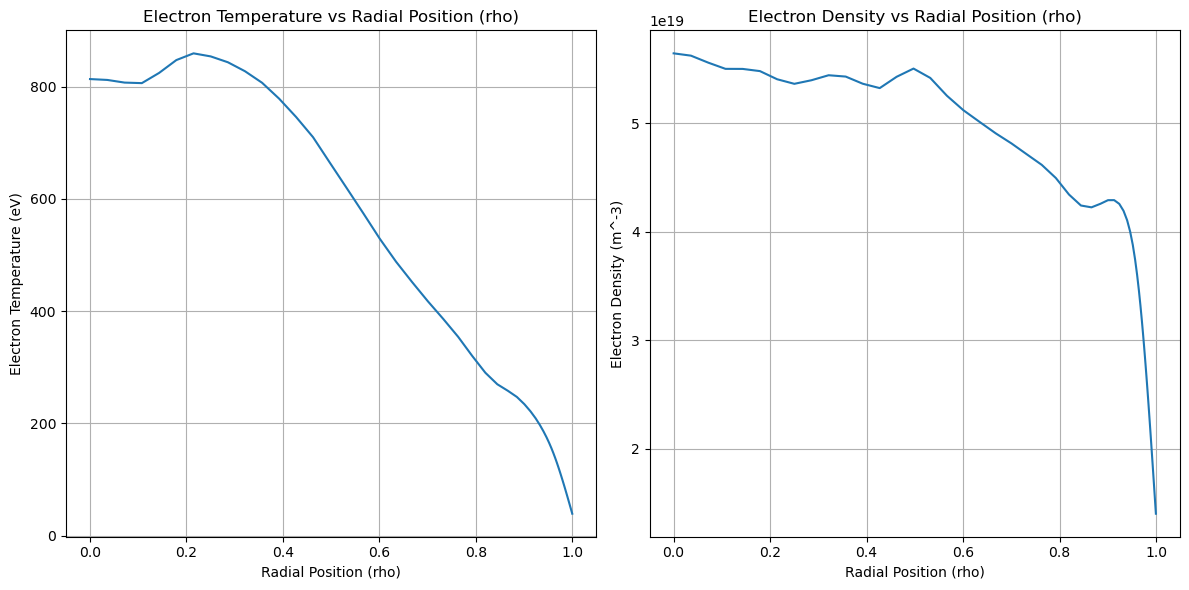

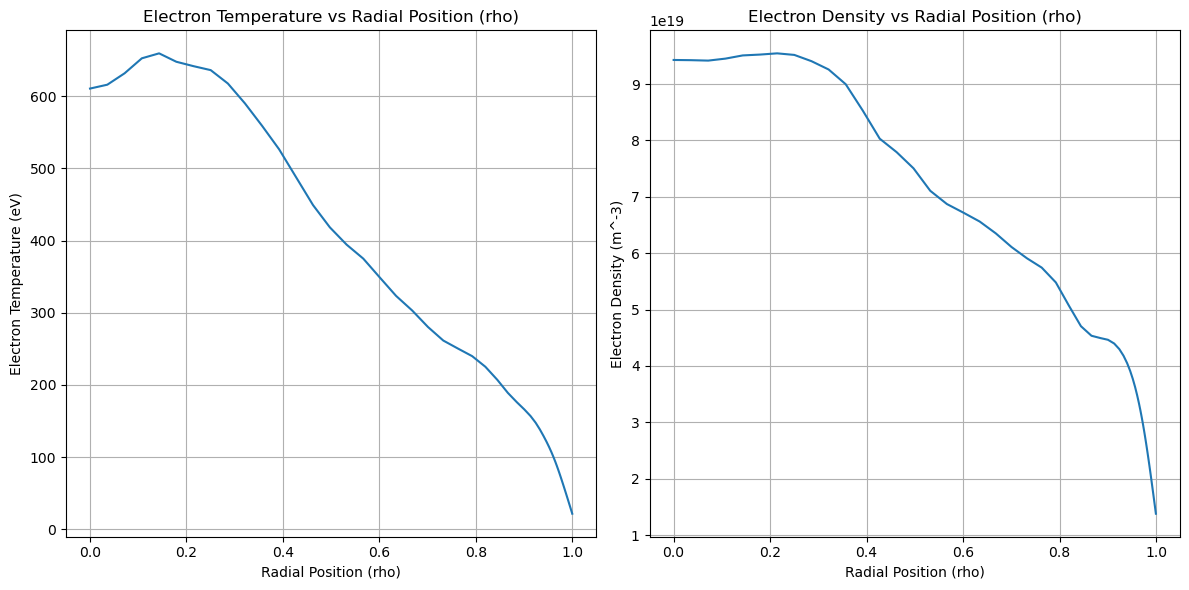

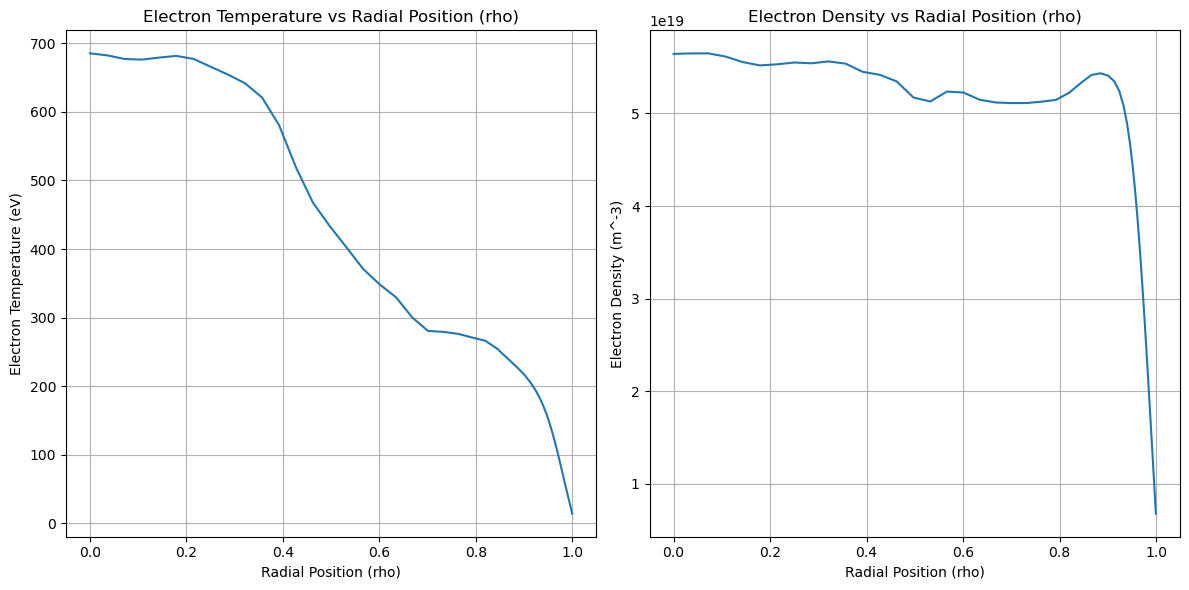

In [17]:
rho_values = [0., 0.03584486, 0.07166301, 0.10745117, 0.14320551, 0.17892153, 0.21459391, 0.25021631, 0.28578111, 0.32127913,
     0.35669915, 0.39202732, 0.42724651, 0.46233524, 0.49726599, 0.53200355, 0.56650207, 0.60070116, 0.63452037, 0.66785046,
     0.70053922, 0.73238545, 0.76310851, 0.79233191, 0.81960084, 0.84438884, 0.86621147, 0.88488211, 0.90042596, 0.91324174,
     0.9238429 , 0.93263444, 0.94011197, 0.94640182, 0.95185597, 0.95662188, 0.96083766, 0.96460302, 0.96775462, 0.97063042,
     0.97301786, 0.97524752, 0.97692543, 0.97860335, 0.98015002, 0.98125109, 0.98235216, 0.98345322, 0.98455429, 0.98550811,
     0.9863873 , 0.98726649, 0.98814569, 0.98902488, 0.98990407, 0.9908116 , 0.99172068, 0.99262977, 0.99353885, 0.99444794,
     0.99528765, 0.9960317 , 0.99677576, 0.99751981, 0.99826387, 0.99900793, 0.99975198] 
    

def plot_temperature_and_density_vs_rho(Te_rho_zXX, Ne_rho_zXX, rho_values):
      
    
        plt.figure(figsize=(12, 6))
    
        # Plot Electron Temperature vs. Rho
        plt.subplot(1, 2, 1) 
        
        plt.plot(rho_values, Te_rho_zXX, label=f'Te')
        
        plt.title('Electron Temperature vs Radial Position (rho)')
        plt.xlabel('Radial Position (rho)')
        plt.ylabel('Electron Temperature (eV)')
        plt.grid(True)
    
        # Plot Electron Density vs. Rho
        plt.subplot(1, 2, 2)  
        
        plt.plot(rho_values, Ne_rho_zXX, label='Ne')
        
        plt.title('Electron Density vs Radial Position (rho)')
        plt.xlabel('Radial Position (rho)')
        plt.ylabel('Electron Density (m^-3)')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))  # Format y-axis in scientific notation
    

        plt.grid(True)
    
        # Show the plot
        plt.tight_layout()
        plt.show()

#We will plot the value collected from three time points : 100ms before the Phase Transition, the time of the of the Phase Transition and 100 ms after 
time_values = [HL_times[shot_number][0] -0.1, HL_times[shot_number][0], HL_times[shot_number][0] + 0.1]

for time_value in time_values:
    
    data_transition = shot_data.loc[shot_data['time'] == time_value]
    
    Te_rho_zXX = []
    Ne_rho_zXX = []
  
    
    # Loop over z positions from z1 to z67
    for z in range(1, 68):
        
        Te_rho_zXX.append(data_transition.get(f'Te_rho_z{z}', None))
        Ne_rho_zXX.append(data_transition.get(f'Ne_rho_z{z}', None))
       
    
    
   
    
    plot_temperature_and_density_vs_rho(Te_rho_zXX, Ne_rho_zXX, rho_values)
    



The plot displays the values of electron density and temperature for the selected shot at three different time points: before (upper figure), during (middle figure), and after (bottom figure) the phase transition between H-mode and L-mode. 100 ms before the phase transition, the plasma is in H-mode, characterized by higher temperature and elevated electron density. As the phase transition occurs, there is a significant decrease in temperature and a sharp increase in density. During the transition, plasma instabilities may cause fluctuations in the profile, with a temporary rise in electron density, particularly in the peripheral regions. At the exact moment the transition progresses from H-mode to L-mode, the gradient from core to edge becomes much steeper. 100 ms after the phase transition, the plasma temperaure increases but is nonetheless lower than before the transition (consistent with the fact the plasma passed from H to L mode). The density decreases again, signaling a transition to L-mode, where the plasma becomes less stable and less efficient at retaining energy. Across all three profiles, we consistently observe a decrease in both temperature and electron density from the core to the edge. Notably, the differences between the phases are more pronounced in electron density than in temperature. 

### Heatmap of Line Integrated Density (FIR_LIDs) for Different Regions ###
Finally, we also plot a heatmap of the FIR_LIDs_core, FIR_LIDs_LFS, and FIR_LIDs_HFS over time to visualize how the electron density varies at different positions (core, low-field side, high-field side).
In fact, changes in the electron density across different regions could signal changes in plasma stability and potential transitions from high to low states.


HL trantion at times:
0.8373
1.0396


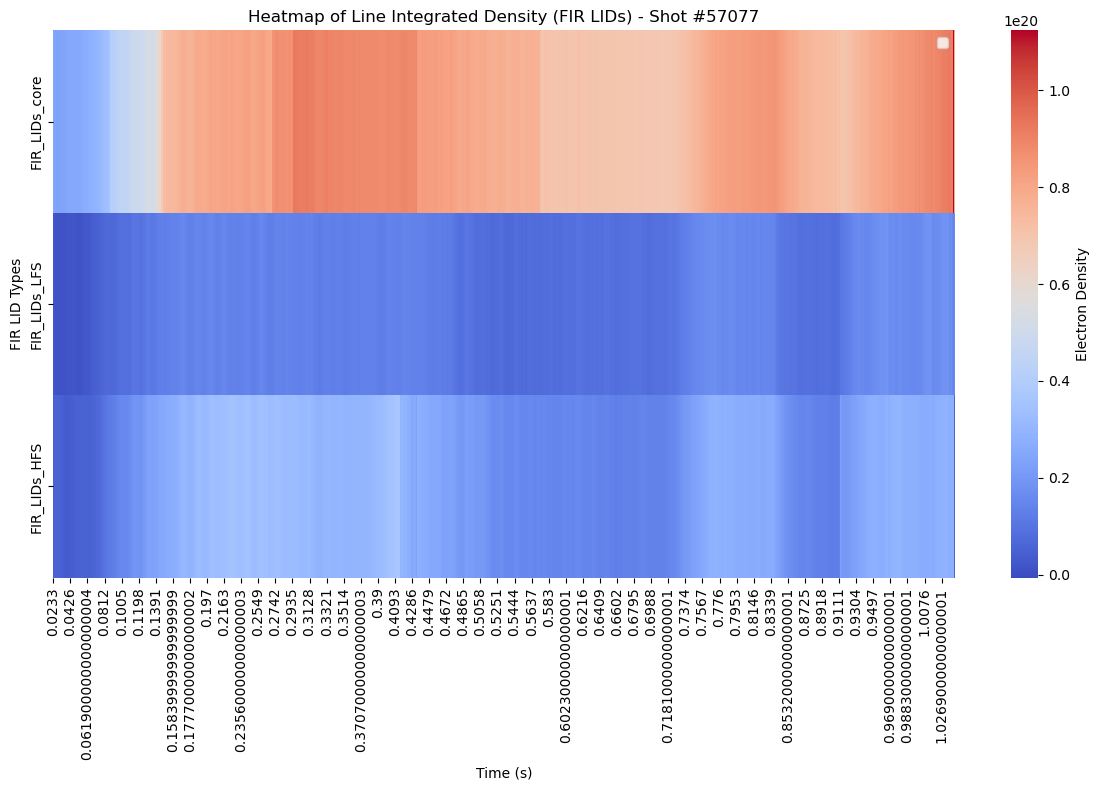

In [20]:
plt.figure(figsize=(12, 8))
heatmap_data = shot_data[['time', 'FIR_LIDs_core', 'FIR_LIDs_LFS', 'FIR_LIDs_HFS']].set_index('time')
ax = sns.heatmap(heatmap_data.T, cmap='coolwarm', cbar_kws={'label': 'Electron Density'})

print ("HL trantion at times:")
# Add vertical lines for H-mode transitions (if applicable)
for hl_time in (HL_times[shot_number]):
   print (hl_time)
# Title for the heatmap
ax.set_title(f'Heatmap of Line Integrated Density (FIR LIDs) - Shot #{shot_number}')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('FIR LID Types')
# Adding a legend for the transitions (remove duplicates)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

## Exploration of structure of the dataset ## 
We continue our analysis by exploring the structure of the dataset. 
We begin by examining various combinations of features to gain a deeper understanding of the data available for our experiments. Each combination represents a distinct subset of features, enabling us to assess how individual features and their interactions contribute to the overall analysis. This exploration will help us identify key factors influencing the back-transition from H mode to L mode and guide the development of our predictive model.


In [22]:
 # Path to the directory containing .parquet files
folder_path = '3_4_LH_HL_data'

# Dictionary to count occurrences of each combination
combination_counts = {}
unique_combinations_indexes = []
shot_index = 0

# Iterate through all .parquet files in the folder
for file in os.listdir(folder_path):
    # Load the parquet file
    file_path = os.path.join(folder_path, file)
    data = pd.read_parquet(file_path)

    # Extracted  experiment number as an integer
    shot_number = int(re.search(r"TCV_DATAno(\d{5})build\.parquet", file).group(1))  
    # Get the sorted list of features (column names)
    features = tuple(sorted(data.columns))
    
    # Update the count for the feature combination
    if features not in combination_counts:
        combination_counts[features] = [shot_number]  # Initialize count
        unique_combinations_indexes.append(shot_index) 

    else:
        combination_counts[features].append(shot_number)
    shot_index += 1   


# Sort combinations by the number of features (keys in combination_counts)
sorted_combinations = sorted(combination_counts.items(), key=lambda x: len(x[0]))

# Output results
print("Number of unique feature combinations:", len(combination_counts))
for i, (features, list_experiments) in enumerate(sorted_combinations): 
    print(f"Features {i}: {features}")
    print(f"Features {i}: {list_experiments}, Count: {len(list_experiments)}")

print("Total count experiments",shot_index)

Number of unique feature combinations: 11
Features 0: ('DML', 'FIR_LIDs_HFS', 'FIR_LIDs_LFS', 'FIR_LIDs_core', 'Halpha13', 'IP', 'IPLA', 'PECRH', 'POHM', 'SXRcore', 'Wtot', 'Z_axis', 'time')
Features 0: [30043, 30197, 30225, 30262, 30268, 30310, 31211, 31554, 31650, 31718, 31807, 31839, 32191, 32195, 32592, 32716, 32911, 33188, 33281, 33459, 33942, 34010, 34309, 43454, 70777], Count: 25
Features 1: ('DML', 'FIR_LIDs_HFS', 'FIR_LIDs_LFS', 'FIR_LIDs_core', 'Halpha13', 'IP', 'IPLA', 'PECRH', 'PNBI', 'POHM', 'Wtot', 'Z_axis', 'time')
Features 1: [76304], Count: 1
Features 2: ('DML', 'FIR_LIDs_HFS', 'FIR_LIDs_LFS', 'FIR_LIDs_core', 'Halpha13', 'IP', 'IPLA', 'PECRH', 'PNBI', 'POHM', 'SXRcore', 'Wtot', 'Z_axis', 'time')
Features 2: [63878, 65391, 68631, 68693, 68697, 68984, 69113], Count: 7
Features 3: ('DML', 'FIR_LIDs_HFS', 'FIR_LIDs_LFS', 'FIR_LIDs_core', 'Halpha13', 'IP', 'IPLA', 'Ne_rho_z1', 'Ne_rho_z10', 'Ne_rho_z11', 'Ne_rho_z12', 'Ne_rho_z13', 'Ne_rho_z14', 'Ne_rho_z2', 'Ne_rho_z3', '

### Most common feature combination ###
Out of 297 experiments, 187 experiments have the feature combination 9 that is one of the most complete with 148 features.
Here is a list of all the 


### The difference between feature combination 9 and the other combination ###
As feature combination 9 is the most common in the dataset we look at the different features present in combination 9 and absent in the others and viceversa:

In [25]:
# Define the target combination (e.g., Combination 9)
idx_target = 9
target_combination = sorted_combinations[idx_target][0]  

# Compare each combination against the target
for idx, (features, count) in enumerate(sorted_combinations):
    if idx == idx_target:
        continue  # Skip comparison with itself

    # Convert tuples to sets for easier comparison
    features_set = set(features)
    target_set = set(target_combination)

    # Compute differences
    only_in_comb = features_set - target_set  # Features in the current combination but not in target
    only_in_target = target_set - features_set  # Features in the target but not in the current combination

    # Print the results
    print(f"Comparison with Combination {idx}:")
    print(f"  Present only in Combination {idx} but absent in Combination 9: {', '.join(only_in_comb) if only_in_comb else 'None'}")
    print(f"  Present in in Combination 9 but absent in Combination {idx}: {', '.join(only_in_target) if only_in_target else 'None'}")
    print("-" * 50)

Comparison with Combination 0:
  Present only in Combination 0 but absent in Combination 9: None
  Present in in Combination 9 but absent in Combination 0: Te_rho_z34, Ne_rho_z32, Te_rho_z43, Ne_rho_z8, Te_rho_z38, Te_rho_z25, Te_rho_z51, Ne_rho_z47, Ne_rho_z12, Ne_rho_z25, Ne_rho_z2, Ne_rho_z34, Ne_rho_z46, Te_rho_z29, Te_rho_z65, Ne_rho_z4, Ne_rho_z10, Ne_rho_z30, Te_rho_z27, Te_rho_z28, Te_rho_z64, Te_rho_z33, Ne_rho_z29, Te_rho_z37, Ne_rho_z42, Te_rho_z48, Te_rho_z17, Ne_rho_z43, Ne_rho_z56, Ne_rho_z5, Te_rho_z14, Ne_rho_z66, Te_rho_z4, Ne_rho_z52, Ne_rho_z9, Te_rho_z49, Ne_rho_z40, Ne_rho_z35, Te_rho_z45, Ne_rho_z49, Ne_rho_z3, Te_rho_z57, Te_rho_z42, Te_rho_z46, Ne_rho_z36, Ne_rho_z55, Te_rho_z41, Te_rho_z39, Te_rho_z15, Te_rho_z21, Te_rho_z44, Te_rho_z58, Ne_rho_z20, Te_rho_z36, Ne_rho_z23, Te_rho_z1, Te_rho_z53, Te_rho_z13, Te_rho_z59, Te_rho_z61, Te_rho_z12, Te_rho_z62, Ne_rho_z27, Ne_rho_z51, Te_rho_z23, Ne_rho_z57, Te_rho_z7, Ne_rho_z14, Ne_rho_z18, Ne_rho_z15, Ne_rho_z19, T

### Combination 9 as target combination ###
We take combination 9 as target combination for the next part of the exploration, considering that except for features combiantions 0, 1, 2 and 3 3 (who lack many features), the differences between combination 9 and the others are only a couple of features.

### Nan percentage ###
Knowing the features and the possible combinations of them present in the dataset we then checked for Nans percentage in the columns of each experiment file.

In [28]:
# Lists to categorize experiments
high_nan_experiments = []
no_nan_experiments = []
low_nan_experiments = []

# Iterate through all .parquet files in the folder
for file in os.listdir(folder_path):
   
    # Load the parquet file
    file_path = os.path.join(folder_path, file)
    data = pd.read_parquet(file_path)
    # Calculate percentage of NaNs for each column
    nan_percentage = (data.isna().sum(axis=0) / data.shape[0]) * 100
    
    # Categorize the experiment based on NaN percentages
    if (nan_percentage > 50).any():
        high_nan_experiments.append(file)
    elif (nan_percentage == 0).all():
        no_nan_experiments.append(file)
    else:
        low_nan_experiments.append(file)
    

# Print the results
print("Experiments with columns with High Percentage (>50%) of NaNs are:", len(high_nan_experiments))
print(high_nan_experiments)
print("\nExperiments with all Columns with No NaNs: are:", len(no_nan_experiments))
print(no_nan_experiments)
print("\nExperiments with columns with Low Percentage of NaNs (<= 50%) are:", len(low_nan_experiments))
print(low_nan_experiments)




Experiments with columns with High Percentage (>50%) of NaNs are: 11
['TCV_DATAno30310build.parquet', 'TCV_DATAno31211build.parquet', 'TCV_DATAno32592build.parquet', 'TCV_DATAno42514build.parquet', 'TCV_DATAno53601build.parquet', 'TCV_DATAno53623build.parquet', 'TCV_DATAno53625build.parquet', 'TCV_DATAno53627build.parquet', 'TCV_DATAno64371build.parquet', 'TCV_DATAno64373build.parquet', 'TCV_DATAno64374build.parquet']

Experiments with all Columns with No NaNs: are: 1
['TCV_DATAno70777build.parquet']

Experiments with columns with Low Percentage of NaNs (<= 50%) are: 285
['TCV_DATAno26386build.parquet', 'TCV_DATAno29511build.parquet', 'TCV_DATAno30043build.parquet', 'TCV_DATAno30197build.parquet', 'TCV_DATAno30225build.parquet', 'TCV_DATAno30262build.parquet', 'TCV_DATAno30268build.parquet', 'TCV_DATAno30290build.parquet', 'TCV_DATAno31554build.parquet', 'TCV_DATAno31650build.parquet', 'TCV_DATAno31718build.parquet', 'TCV_DATAno31807build.parquet', 'TCV_DATAno31839build.parquet', 'TCV_

### For a specific experiment ###
Modify the shot_data index in the beginning of the notebook to change experiment

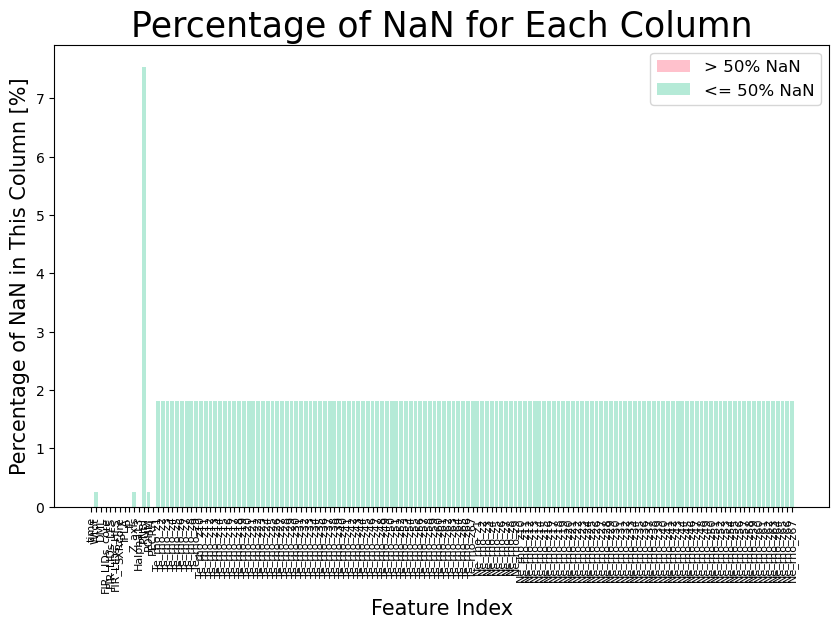

In [30]:
# Check for NaNs and compute percentages
nan_indices = shot_data.isna()
percentage = (nan_indices.sum(axis=0) / shot_data.shape[0]) * 100

# Visualization
x = np.arange(len(percentage))
plt.figure(figsize=(10, 6))

# Use pastel colors based on the percentage threshold
colors = ['#FFC1CC' if p > 50 else '#B5EAD7' for p in percentage]

# Plot the bar chart
bars = plt.bar(x, percentage, color=colors)
plt.title('Percentage of NaN for Each Column', fontsize=25)
plt.xlabel('Feature Index', fontsize=15)
plt.ylabel('Percentage of NaN in This Column [%]', fontsize=15)

# Create dummy artists for the legend
pink_proxy = plt.Rectangle((0, 0), 1, 1, fc='#FFC1CC')  # pastel pink
green_proxy = plt.Rectangle((0, 0), 1, 1, fc='#B5EAD7')  # mint green

# Create the legend
plt.legend([pink_proxy, green_proxy], ['> 50% NaN', '<= 50% NaN'], loc='upper right', fontsize=12)

# Show the plot
plt.xticks(x, shot_data.columns, rotation=90, fontsize=8)
plt.show()

In [31]:
n_rows = shot_data.shape[1]
print("total number of colums:", n_rows)
no_nan_columns = [i for i, p in enumerate(percentage) if p == 0]
print("How many columns don't have nans?",len(no_nan_columns))
column_names = shot_data.columns[no_nan_columns]
print("no NANs colums:",column_names)
#  Create two lists: one for high percentage of NaN and one for low percentage
high_nan_columns = [i for i, p in enumerate(percentage) if p > 50]
low_nan_columns = [i for i, p in enumerate(percentage) if p <= 50 ]

print("How many columns have highwer nans percentage (>50%)?",len(high_nan_columns))
print("How many colums have low nans percentage (<50%)?",len(low_nan_columns))
# Print the first 10 columns for high and low percentage of NaN
print("First 10 columns with highest percentage of NaN in dataset (> 50%):", shot_data.columns[high_nan_columns[:10]])
print("Columns with very low percentage of NaN (<= 50%):", shot_data.columns[low_nan_columns])

total number of colums: 148
How many columns don't have nans? 10
no NANs colums: Index(['time', 'DML', 'FIR_LIDs_core', 'FIR_LIDs_LFS', 'FIR_LIDs_HFS',
       'SXRcore', 'IPLA', 'IP', 'Halpha13', 'PECRH'],
      dtype='object')
How many columns have highwer nans percentage (>50%)? 0
How many colums have low nans percentage (<50%)? 148
First 10 columns with highest percentage of NaN in dataset (> 50%): Index([], dtype='object')
Columns with very low percentage of NaN (<= 50%): Index(['time', 'Wtot', 'DML', 'FIR_LIDs_core', 'FIR_LIDs_LFS', 'FIR_LIDs_HFS',
       'SXRcore', 'IPLA', 'IP', 'Z_axis',
       ...
       'Ne_rho_z58', 'Ne_rho_z59', 'Ne_rho_z60', 'Ne_rho_z61', 'Ne_rho_z62',
       'Ne_rho_z63', 'Ne_rho_z64', 'Ne_rho_z65', 'Ne_rho_z66', 'Ne_rho_z67'],
      dtype='object', length=148)


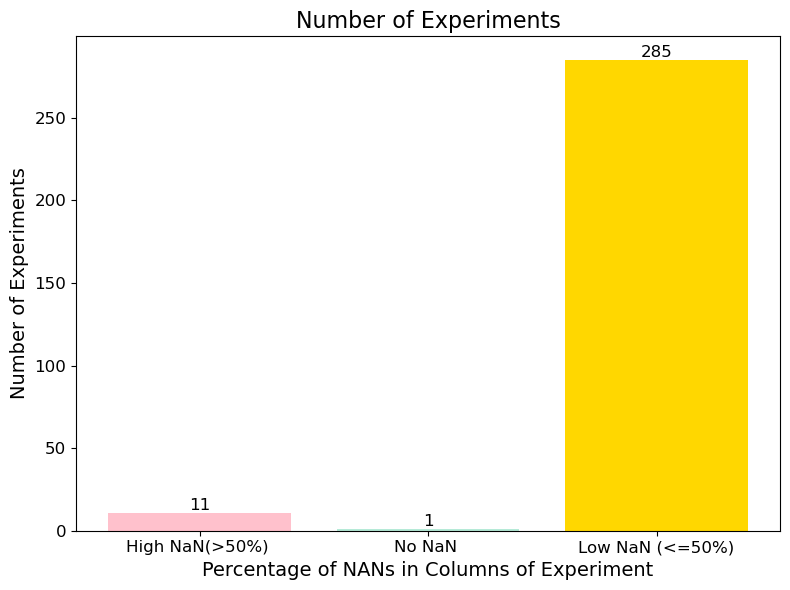

In [32]:
categories = ['High NaN(>50%) ', 'No NaN ', 'Low NaN (<=50%)']
counts = [
    len(high_nan_experiments),
    len(no_nan_experiments),
    len(low_nan_experiments)
]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['#FFC1CC', '#B5EAD7', '#FFD700'])

# Add value annotations above the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=12)

# Customize the plot
plt.title('Number of Experiments', fontsize=16)
plt.xlabel('Percentage of NANs in Columns of Experiment', fontsize=14) 
plt.yticks(fontsize=12)
plt.ylabel('Number of Experiments', fontsize=14)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

### Nan percentage in experiments ###
We can observe very patterns in the dataset regarding columns with NaN values in the different experiments:

1. **Experiments with columns with High Percentage (>50%) of NaNs**:  just 11, out of 297 total experiments
  
2. **Experiments with all Columns with No NaNs**:   just 1

3. **Experiments with columns with Low Percentage of NaNs (<= 50%)**: The majority of experiments—285 out of 297—belong to this category, indicating a favorable distribution of missing values.



In [34]:
# Define the target feature combination
target_combination = [
    'DML', 'FIR_LIDs_HFS', 'FIR_LIDs_LFS', 'FIR_LIDs_core', 'Halpha13', 'IP',
    'IPLA', 'Ne_rho_z1', 'Ne_rho_z10', 'Ne_rho_z11', 'Ne_rho_z12', 'Ne_rho_z13',
    'Ne_rho_z14', 'Ne_rho_z15', 'Ne_rho_z16', 'Ne_rho_z17', 'Ne_rho_z18',
    'Ne_rho_z19', 'Ne_rho_z2', 'Ne_rho_z20', 'Ne_rho_z21', 'Ne_rho_z22',
    'Ne_rho_z23', 'Ne_rho_z24', 'Ne_rho_z25', 'Ne_rho_z26', 'Ne_rho_z27',
    'Ne_rho_z28', 'Ne_rho_z29', 'Ne_rho_z3', 'Ne_rho_z30', 'Ne_rho_z31',
    'Ne_rho_z32', 'Ne_rho_z33', 'Ne_rho_z34', 'Ne_rho_z35', 'Ne_rho_z36',
    'Ne_rho_z37', 'Ne_rho_z38', 'Ne_rho_z39', 'Ne_rho_z4', 'Ne_rho_z40',
    'Ne_rho_z41', 'Ne_rho_z42', 'Ne_rho_z43', 'Ne_rho_z44', 'Ne_rho_z45',
    'Ne_rho_z46', 'Ne_rho_z47', 'Ne_rho_z48', 'Ne_rho_z49', 'Ne_rho_z5',
    'Ne_rho_z50', 'Ne_rho_z51', 'Ne_rho_z52', 'Ne_rho_z53', 'Ne_rho_z54',
    'Ne_rho_z55', 'Ne_rho_z56', 'Ne_rho_z57', 'Ne_rho_z58', 'Ne_rho_z59',
    'Ne_rho_z6', 'Ne_rho_z60', 'Ne_rho_z61', 'Ne_rho_z62', 'Ne_rho_z63',
    'Ne_rho_z64', 'Ne_rho_z65', 'Ne_rho_z66', 'Ne_rho_z67', 'Ne_rho_z7',
    'Ne_rho_z8', 'Ne_rho_z9', 'PECRH', 'POHM', 'SXRcore', 'Te_rho_z1',
    'Te_rho_z10', 'Te_rho_z11', 'Te_rho_z12', 'Te_rho_z13', 'Te_rho_z14',
    'Te_rho_z15', 'Te_rho_z16', 'Te_rho_z17', 'Te_rho_z18', 'Te_rho_z19',
    'Te_rho_z2', 'Te_rho_z20', 'Te_rho_z21', 'Te_rho_z22', 'Te_rho_z23',
    'Te_rho_z24', 'Te_rho_z25', 'Te_rho_z26', 'Te_rho_z27', 'Te_rho_z28',
    'Te_rho_z29', 'Te_rho_z3', 'Te_rho_z30', 'Te_rho_z31', 'Te_rho_z32',
    'Te_rho_z33', 'Te_rho_z34', 'Te_rho_z35', 'Te_rho_z36', 'Te_rho_z37',
    'Te_rho_z38', 'Te_rho_z39', 'Te_rho_z4', 'Te_rho_z40', 'Te_rho_z41',
    'Te_rho_z42', 'Te_rho_z43', 'Te_rho_z44', 'Te_rho_z45', 'Te_rho_z46',
    'Te_rho_z47', 'Te_rho_z48', 'Te_rho_z49', 'Te_rho_z5', 'Te_rho_z50',
    'Te_rho_z51', 'Te_rho_z52', 'Te_rho_z53', 'Te_rho_z54', 'Te_rho_z55',
    'Te_rho_z56', 'Te_rho_z57', 'Te_rho_z58', 'Te_rho_z59', 'Te_rho_z6',
    'Te_rho_z60', 'Te_rho_z61', 'Te_rho_z62', 'Te_rho_z63', 'Te_rho_z64',
    'Te_rho_z65', 'Te_rho_z66', 'Te_rho_z67', 'Te_rho_z7', 'Te_rho_z8',
    'Te_rho_z9', 'Wtot', 'Z_axis', 'time'
]

### Correlation  Analysis ###
We will now proceed to explore the correlation between different features

- **Loading Experiments**: A subset of 5 experiments will be loaded from parquet files.
- **Handling Missing Values**: Missing values will be handled using forward fill to ensure continuous data.
- **Filtering Around HL Transitions**: Data will be filtered based on the `HL_times.json` file to focus on observations within a 1-second time window around the HL transitions.

We start by computing the correlation matrix on the full dataset to examine general relationships between features.
The heatmap is created using Seaborn, with the upper triangle of the matrix masked for clarity


C:\Users\virgi\AppData\Local\Temp\ipykernel_19292\2650581030.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data_clean = data_features.fillna(method='ffill')


Number of missing values after forward fill :
DML                0
FIR_LIDs_HFS       0
FIR_LIDs_LFS       0
FIR_LIDs_core      0
Halpha13           0
                ... 
Te_rho_z7        284
Te_rho_z8        284
Te_rho_z9        284
Wtot               0
Z_axis             0
Length: 146, dtype: int64


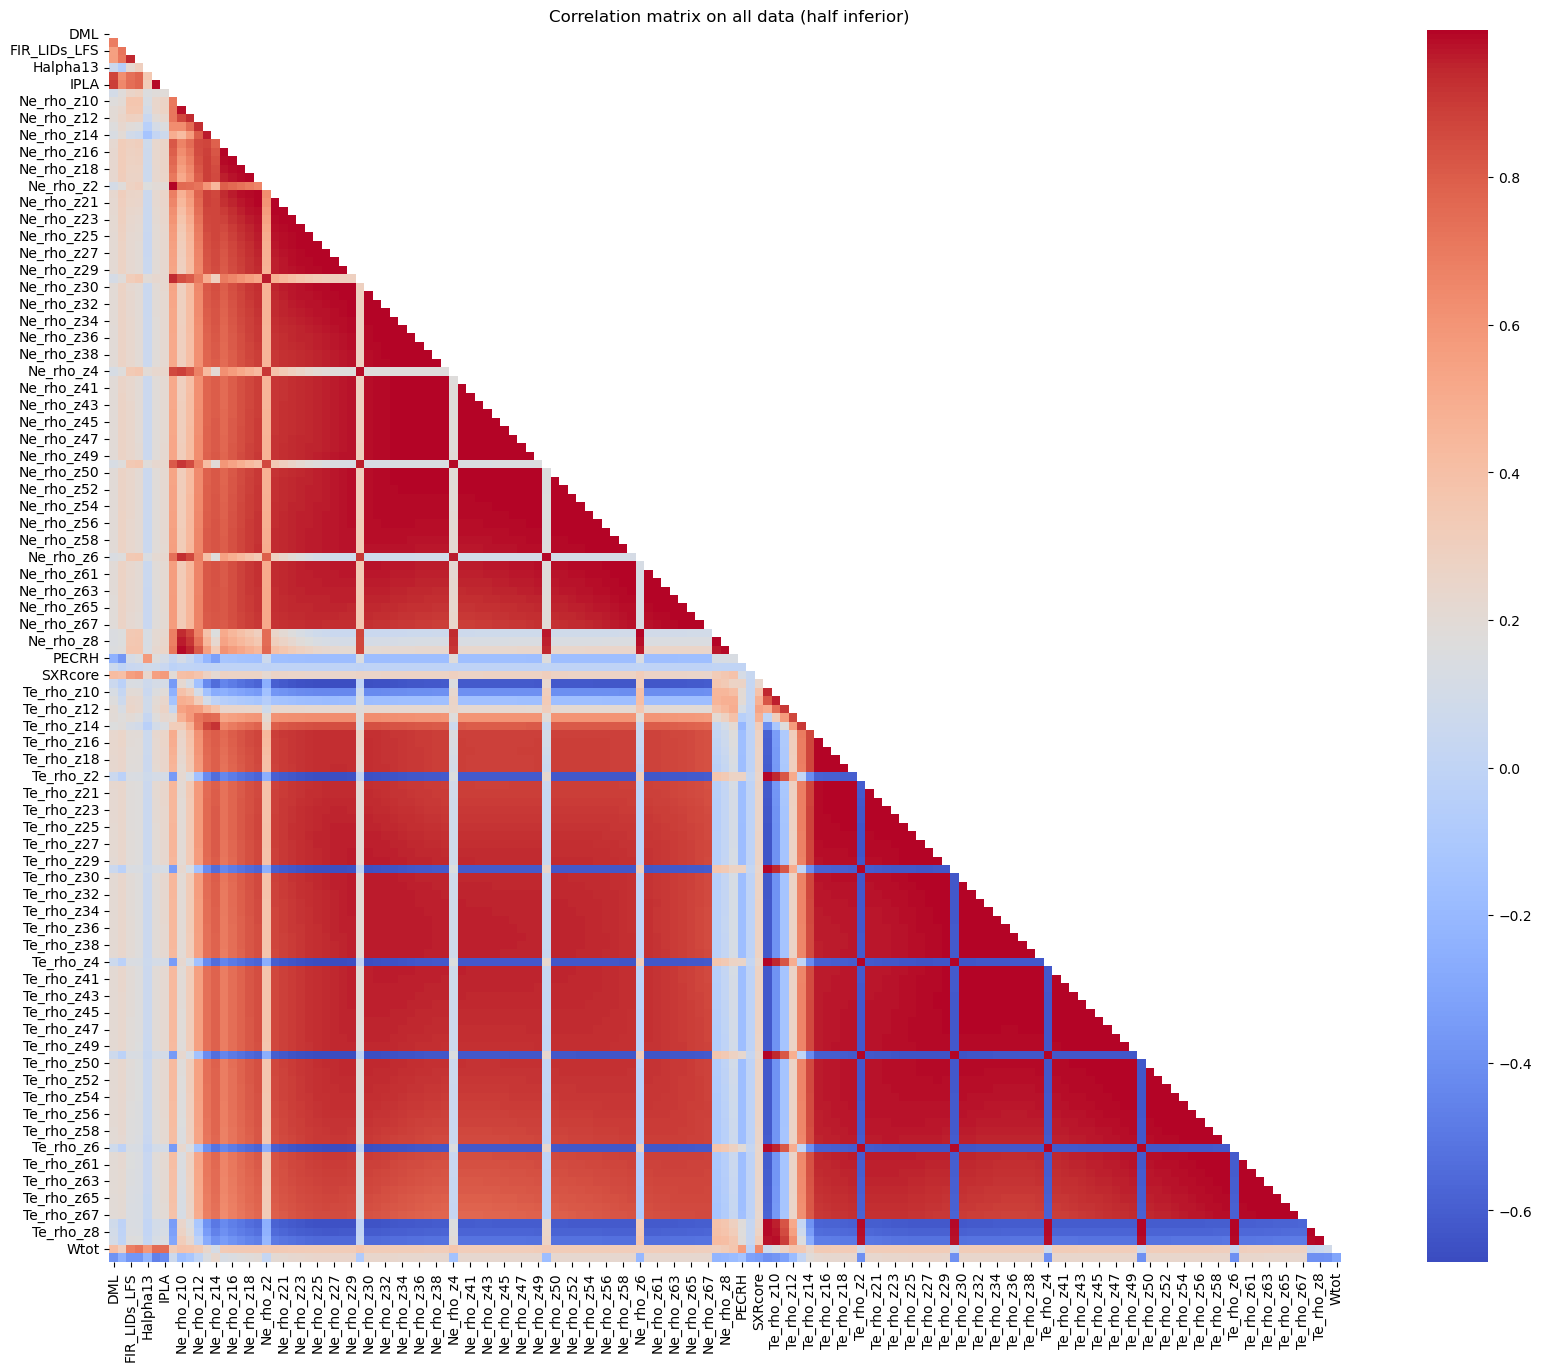

In [36]:
#For 5 experiments from dataset
# Limit to a subset of experiments
N = 5  # Number of experiments to test
subset_shotlist = shotlist_all[:N]  # create a subset

# Load data
data_list = []
#de-comment to have all data
# for shot_number in shotlist_all:
#     shot_data = pd.read_parquet(pq_all[shot_number])
#     shot_data['shot_number'] = shot_number  # Add a column to identify the shot
#     data_list.append(shot_data)
#from the subset created
for shot_number in subset_shotlist:
    shot_data = pd.read_parquet(pq_all[shot_number])
    shot_data['shot_number'] = shot_number  # Ajouter une colonne pour identifier le shot
    data_list.append(shot_data)

# Concatenate all data
all_data = pd.concat(data_list, ignore_index=True)

# Combination of features of interest
features = target_combination.copy()
features.remove('time')  # Exclu 'time'

# Handle missing values
data_features = all_data[features]
all_data_clean = data_features.fillna(method='ffill')

missing_counts = all_data_clean.isnull().sum()
print("Number of missing values after forward fill :")
print(missing_counts)

# Compute correlation matrix
corr_matrix_all = all_data_clean[features].corr()

# Create a mask to hide superior correlation matrix
mask = np.triu(np.ones_like(corr_matrix_all, dtype=bool))

# Display a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_all, mask=mask, cmap='coolwarm', annot=False)
plt.title('Correlation matrix on all data (half inferior)')
plt.show()


Now we will compute the correlation matrix for data around HL transitions

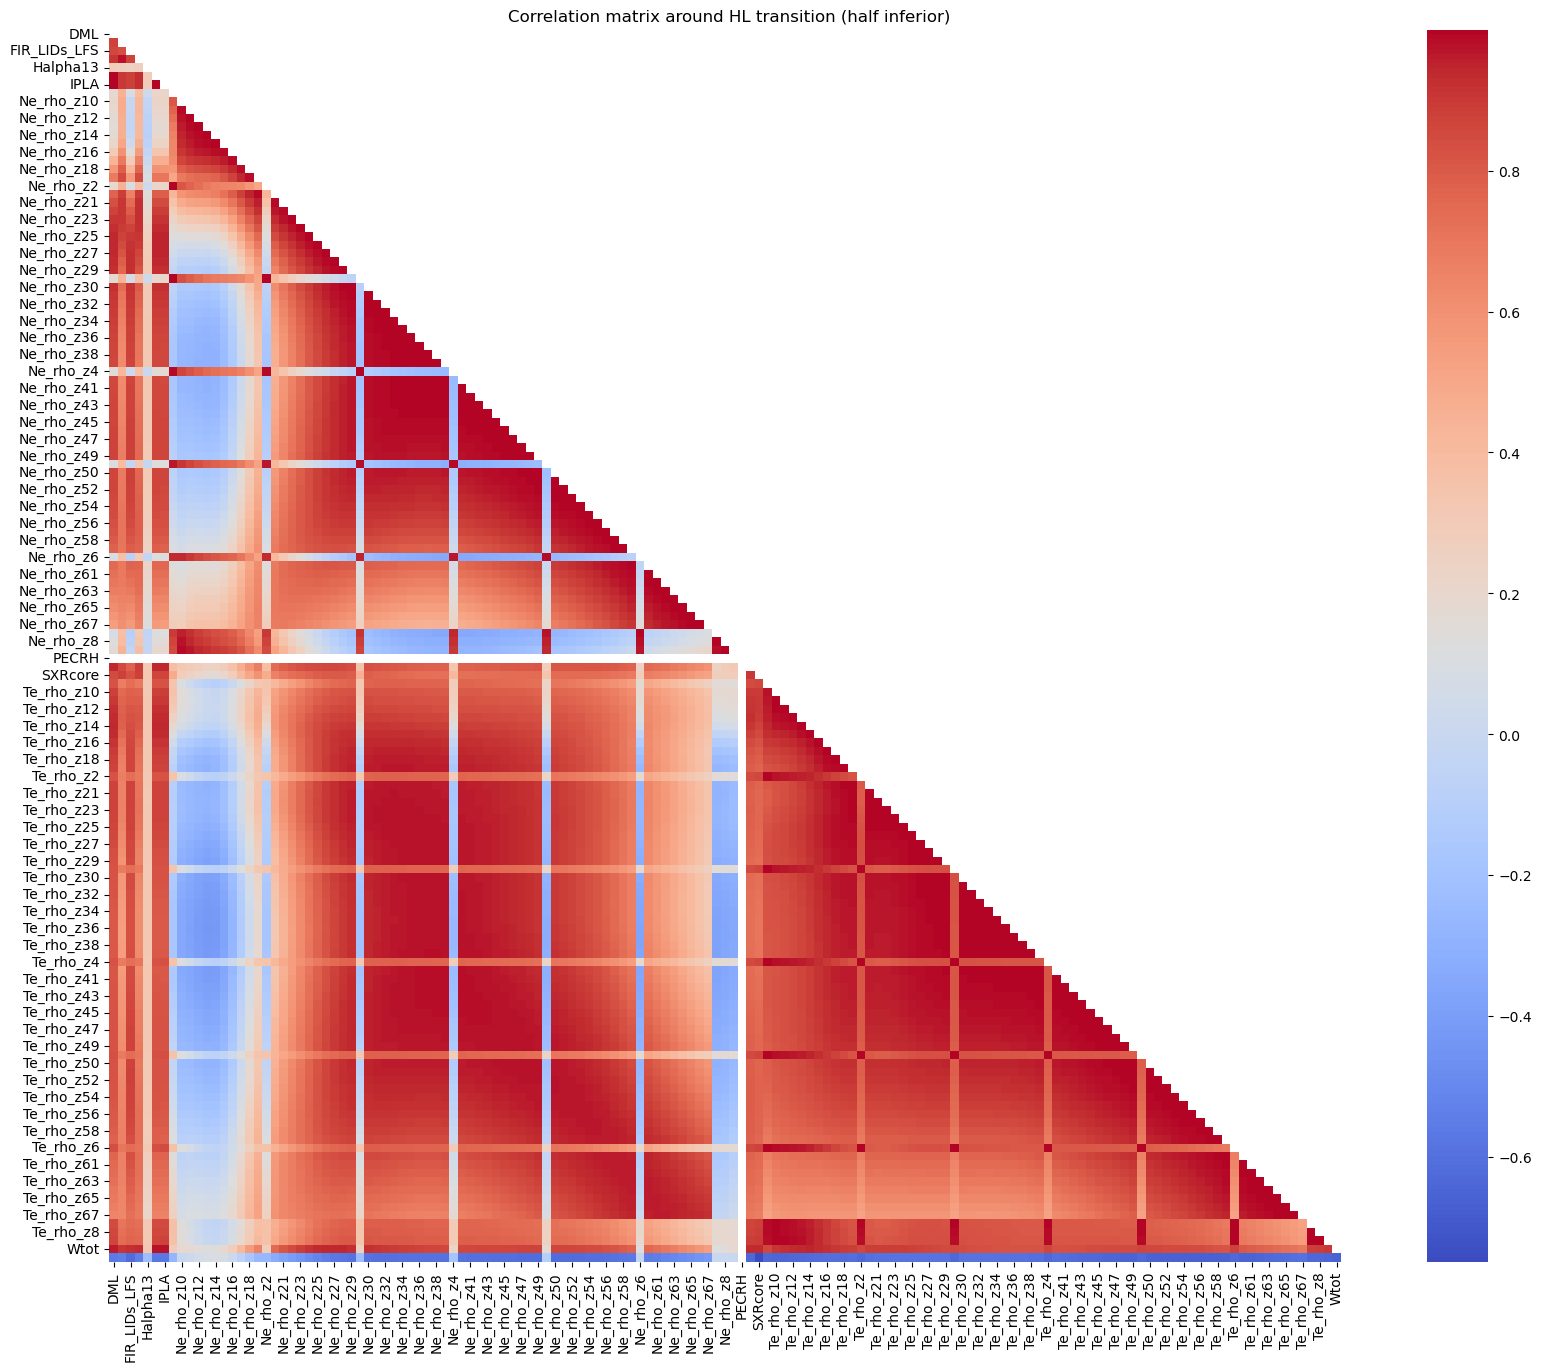

In [38]:
#time filtered dataset
# Define a time window around the transition
transition_window = 1  # Fenêtre de 1 seconde

# Create a list to collect the filtered data
transition_data_list = []

for shot_number, times in HL_times.items():
    # Filter data around the shot
    shot_data = all_data[all_data['shot_number'] == shot_number]
    
    for hl_time in times:
        # Filter data in the time window around the transition HL
        window_data = shot_data[(shot_data['time'] >= hl_time - transition_window / 2) & 
                                (shot_data['time'] <= hl_time + transition_window / 2)]
        transition_data_list.append(window_data)

# Concatenate filtered data
transition_data = pd.concat(transition_data_list, ignore_index=True)

# Handle missing values
transition_data_clean = transition_data.dropna(subset=features)

# Compute correlation matrix on filtered data
corr_matrix_transition = transition_data_clean[features].corr()

# Create a mask
mask = np.triu(np.ones_like(corr_matrix_transition, dtype=bool))

# Display heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_transition, mask=mask, cmap='coolwarm', annot=False)
plt.title('Correlation matrix around HL transition (half inferior)')
plt.show()



We will then move on to identify the pairs of features with correlation coefficients exceeding 0.8.
- We will save the results in the followinf files 
    - `common_pairs.csv`: Pairs found both in the data around HL transitions and in the full dataset.
    - `only_transition_pairs.csv`: Pairs identified only during HL transitions.
    - `only_in_all.csv`: Pairs identified only in the full dataset, but not around HL transitions.



In [40]:
# Define correlation threshold
threshold = 0.8

# For non filtered data
high_corr_all = corr_matrix_all.abs() > threshold
high_corr_pairs_all = high_corr_all.stack().reset_index()
high_corr_pairs_all = high_corr_pairs_all[high_corr_pairs_all[0] & (high_corr_pairs_all['level_0'] != high_corr_pairs_all['level_1'])]
high_corr_pairs_all.columns = ['Feature1', 'Feature2', 'Correlation']

# For filtered data
high_corr_transition = corr_matrix_transition.abs() > threshold
high_corr_pairs_transition = high_corr_transition.stack().reset_index()
high_corr_pairs_transition = high_corr_pairs_transition[high_corr_pairs_transition[0] & (high_corr_pairs_transition['level_0'] != high_corr_pairs_transition['level_1'])]
high_corr_pairs_transition.columns = ['Feature1', 'Feature2', 'Correlation']

# Pairs comparison
common_pairs = pd.merge(high_corr_pairs_all, high_corr_pairs_transition, on=['Feature1', 'Feature2'], how='inner')
unique_to_all = high_corr_pairs_all.merge(high_corr_pairs_transition, on=['Feature1', 'Feature2'], how='outer', indicator=True)
unique_to_all = unique_to_all[unique_to_all['_merge'] == 'left_only']
unique_to_transition = high_corr_pairs_transition.merge(high_corr_pairs_all, on=['Feature1', 'Feature2'], how='outer', indicator=True)
unique_to_transition = unique_to_transition[unique_to_transition['_merge'] == 'left_only']

common_pairs.to_csv("common_pairs.csv")
unique_to_all.to_csv("only_in_all.csv")
unique_to_transition.to_csv("only_in_transition.csv")

print("Highly correlated pairs in data : {} \n et size : {}".format(common_pairs, len(common_pairs)))
print("\nUnique highly correlated pairs in all data : {} et size : {}".format(unique_to_all, len(unique_to_all)))
print("\nUnique highly correlated pairs in filtered data : {} et size : {}".format(unique_to_transition, len(unique_to_transition)))


Highly correlated pairs in data :            Feature1       Feature2  Correlation_x  Correlation_y
0               DML             IP           True           True
1               DML           IPLA           True           True
2      FIR_LIDs_LFS  FIR_LIDs_core           True           True
3     FIR_LIDs_core   FIR_LIDs_LFS           True           True
4                IP            DML           True           True
...             ...            ...            ...            ...
7605      Te_rho_z9      Te_rho_z4           True           True
7606      Te_rho_z9      Te_rho_z5           True           True
7607      Te_rho_z9      Te_rho_z6           True           True
7608      Te_rho_z9      Te_rho_z7           True           True
7609      Te_rho_z9      Te_rho_z8           True           True

[7610 rows x 4 columns] 
 et size : 7610

Unique highly correlated pairs in all data :          Feature1    Feature2 Correlation_x Correlation_y     _merge
439     Ne_rho_z1  Ne_rho_z15

### Principal Component Analysis (PCA) ###
To gain deeper insight in the features that explain most of the variability in the dataset we perform PCA.
- **Imputation**: Missing values will be imputed before performing PCA.
- **Standardization**: Features will be standardized to have zero mean and unit variance.
- **Calculating Loadings**: Loadings will then be computed to understand the contributions of each feature to the principal components.
- **Most Important Features**: The features with the highest absolute loadings on PC1 and PC2 will be identified.
  
To visualize PCA results we will use score plots and biplots to interpret the distribution of data points and the relationship between features in the principal component space.

Loadings on all principal component (all data):
                    PC1       PC2
DML            0.020317 -0.077910
FIR_LIDs_HFS   0.025623 -0.072587
FIR_LIDs_LFS   0.020751 -0.127959
FIR_LIDs_core  0.018867 -0.129363
Halpha13       0.005347 -0.051991
...                 ...       ...
Te_rho_z7     -0.062376 -0.150416
Te_rho_z8     -0.059303 -0.155283
Te_rho_z9     -0.053261 -0.163712
Wtot           0.031683 -0.120236
Z_axis         0.023446  0.096514

[146 rows x 2 columns]

Loadings on all principal component (filtered data):
                    PC1       PC2
DML           -0.089691  0.054211
FIR_LIDs_HFS  -0.072672  0.118544
FIR_LIDs_LFS  -0.089703  0.021082
FIR_LIDs_core -0.078893  0.108413
Halpha13      -0.031723 -0.005443
...                 ...       ...
Te_rho_z7     -0.081395  0.029490
Te_rho_z8     -0.082175  0.031715
Te_rho_z9     -0.083249  0.033656
Wtot          -0.091286  0.056185
Z_axis         0.064327 -0.017253

[146 rows x 2 columns]


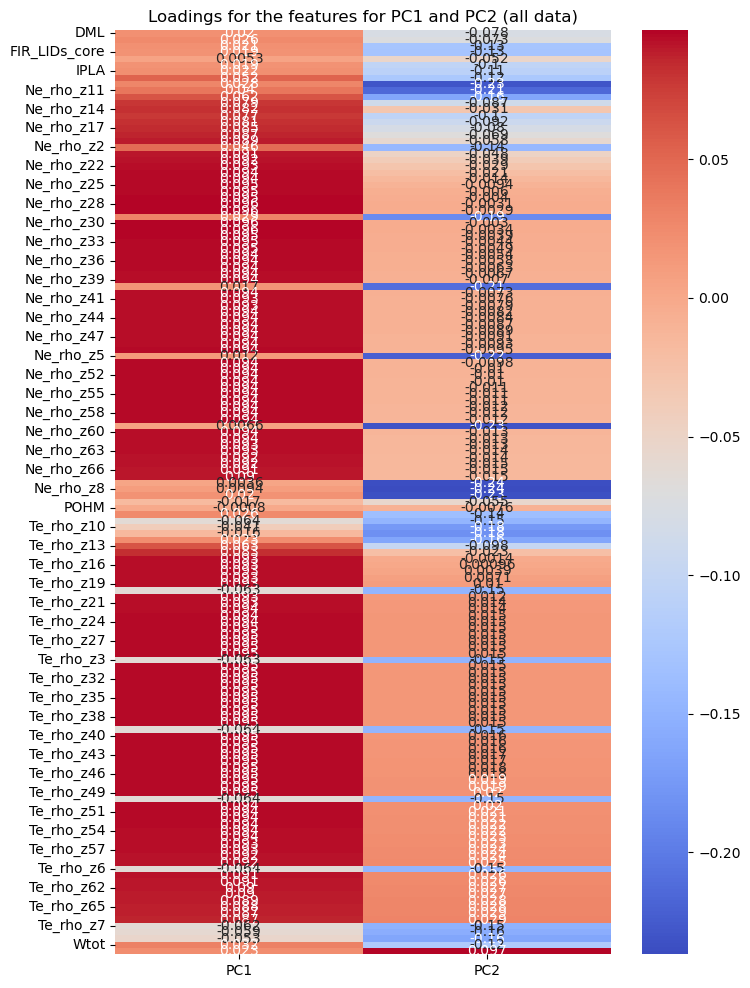

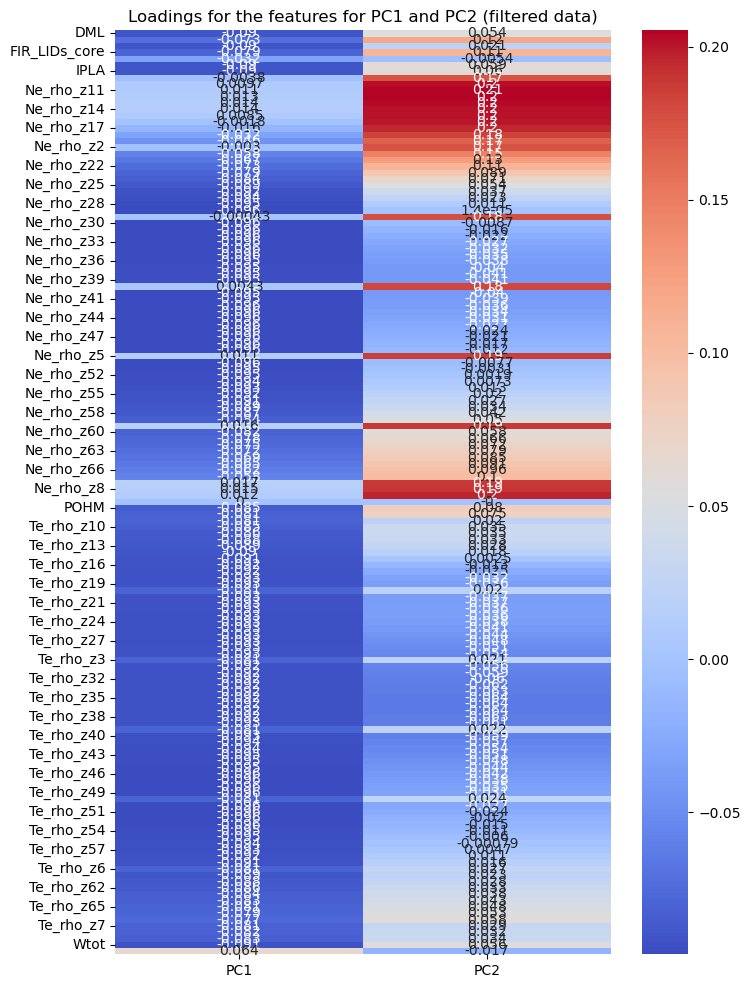


Most important features for PC1 (all data):
Ne_rho_z29    0.095675
Ne_rho_z30    0.095638
Ne_rho_z28    0.095603
Ne_rho_z31    0.095510
Ne_rho_z27    0.095422
Ne_rho_z32    0.095311
Ne_rho_z26    0.095151
Ne_rho_z33    0.095061
Te_rho_z29    0.095037
Te_rho_z30    0.095035
Name: PC1, dtype: float64

Most important features for PC2 (all data):
Ne_rho_z8     0.236748
Ne_rho_z7     0.235341
Ne_rho_z9     0.233796
Ne_rho_z6     0.231309
Ne_rho_z10    0.229697
Ne_rho_z5     0.221779
Ne_rho_z11    0.214999
Ne_rho_z4     0.210159
Ne_rho_z3     0.185983
Te_rho_z11    0.182859
Name: PC2, dtype: float64

Most important features for PC1 (filtered data):
Ne_rho_z31    0.096361
Ne_rho_z30    0.096326
Ne_rho_z32    0.096240
Ne_rho_z47    0.096170
Ne_rho_z46    0.096141
Ne_rho_z48    0.096130
Ne_rho_z45    0.096066
Ne_rho_z29    0.096032
Ne_rho_z33    0.096027
Ne_rho_z49    0.095992
Name: PC1, dtype: float64

Most important features for PC2 (filtered data):
Ne_rho_z11    0.205343
Ne_rho_z12    0.204

In [42]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preprocess data
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# All data
data_imputed_all = pd.DataFrame(imputer.fit_transform(all_data_clean[features]), columns=features)
scaled_data_all = scaler.fit_transform(data_imputed_all)

# Filtered data
data_imputed_transition = pd.DataFrame(imputer.fit_transform(transition_data_clean[features]), columns=features)
scaled_data_transition = scaler.fit_transform(data_imputed_transition)

# PCA on all data
pca_all = PCA(n_components=2)
principal_components_all = pca_all.fit_transform(scaled_data_all)
pca_df_all = pd.DataFrame(data=principal_components_all, columns=['PC1', 'PC2'])

# PCA on filtered data
pca_transition = PCA(n_components=2)
principal_components_transition = pca_transition.fit_transform(scaled_data_transition)
pca_df_transition = pd.DataFrame(data=principal_components_transition, columns=['PC1', 'PC2'])

# Compute loading for all data
loadings_all = pd.DataFrame(pca_all.components_.T, columns=['PC1', 'PC2'], index=features)

# Compute loading for filtered data
loadings_transition = pd.DataFrame(pca_transition.components_.T, columns=['PC1', 'PC2'], index=features)

# Display loading for all data
print("Loadings on all principal component (all data):")
print(loadings_all)

# Display loading for filtered data
print("\nLoadings on all principal component (filtered data):")
print(loadings_transition)

# Visualisation of loadings on heatmap for all data
plt.figure(figsize=(8, 12))
sns.heatmap(loadings_all, annot=True, cmap='coolwarm')
plt.title('Loadings for the features for PC1 and PC2 (all data)')
plt.show()

# Visualisation of loadings on heatmap for filtered data
plt.figure(figsize=(8, 12))
sns.heatmap(loadings_transition, annot=True, cmap='coolwarm')
plt.title('Loadings for the features for PC1 and PC2 (filtered data)')
plt.show()

# Most important features for PC1 and PC2 (all data)
pc1_loadings_all = loadings_all['PC1'].abs().sort_values(ascending=False)
print("\nMost important features for PC1 (all data):")
print(pc1_loadings_all.head(10))

pc2_loadings_all = loadings_all['PC2'].abs().sort_values(ascending=False)
print("\nMost important features for PC2 (all data):")
print(pc2_loadings_all.head(10))

# Most important features for PC1 and PC2 (filtered data)
pc1_loadings_transition = loadings_transition['PC1'].abs().sort_values(ascending=False)
print("\nMost important features for PC1 (filtered data):")
print(pc1_loadings_transition.head(10))

pc2_loadings_transition = loadings_transition['PC2'].abs().sort_values(ascending=False)
print("\nMost important features for PC2 (filtered data):")
print(pc2_loadings_transition.head(10))


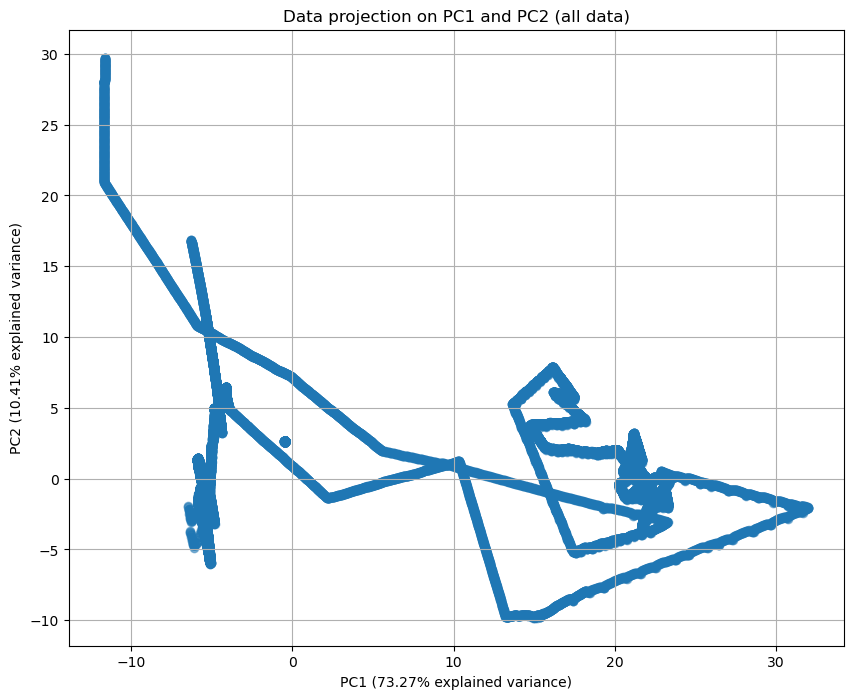

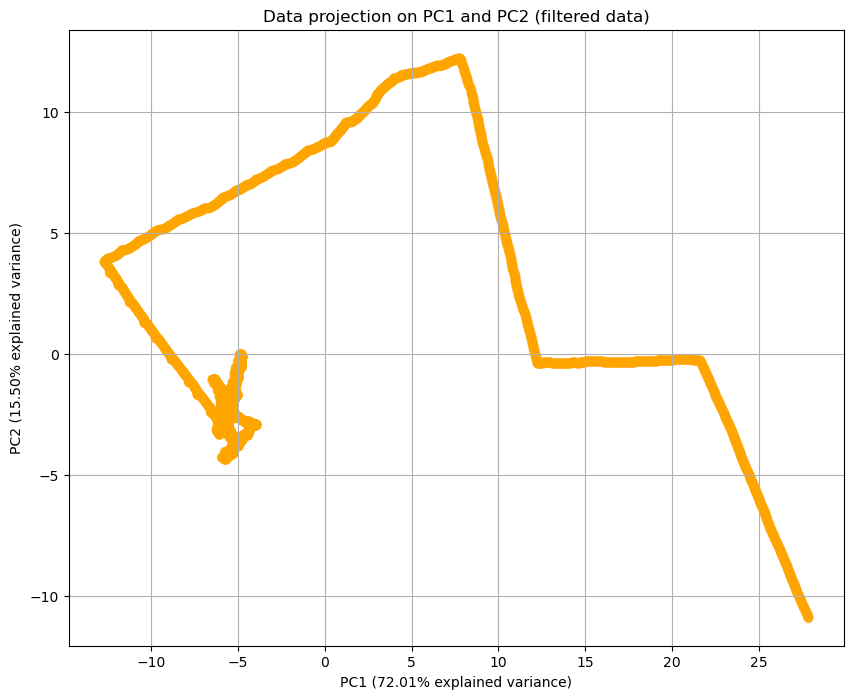

In [43]:
# PCA visualisation for all data
plt.figure(figsize=(10, 8))
plt.scatter(principal_components_all[:, 0], principal_components_all[:, 1], alpha=0.5)
plt.title('Data projection on PC1 and PC2 (all data)')
plt.xlabel(f'PC1 ({pca_all.explained_variance_ratio_[0]*100:.2f}% explained variance)')
plt.ylabel(f'PC2 ({pca_all.explained_variance_ratio_[1]*100:.2f}% explained variance)')
plt.grid()
plt.show()

# PCA visualisation for filtered data
plt.figure(figsize=(10, 8))
plt.scatter(principal_components_transition[:, 0], principal_components_transition[:, 1], alpha=0.5, color='orange')
plt.title('Data projection on PC1 and PC2 (filtered data)')
plt.xlabel(f'PC1 ({pca_transition.explained_variance_ratio_[0]*100:.2f}% explained variance)')
plt.ylabel(f'PC2 ({pca_transition.explained_variance_ratio_[1]*100:.2f}% explained variance)')
plt.grid()
plt.show()


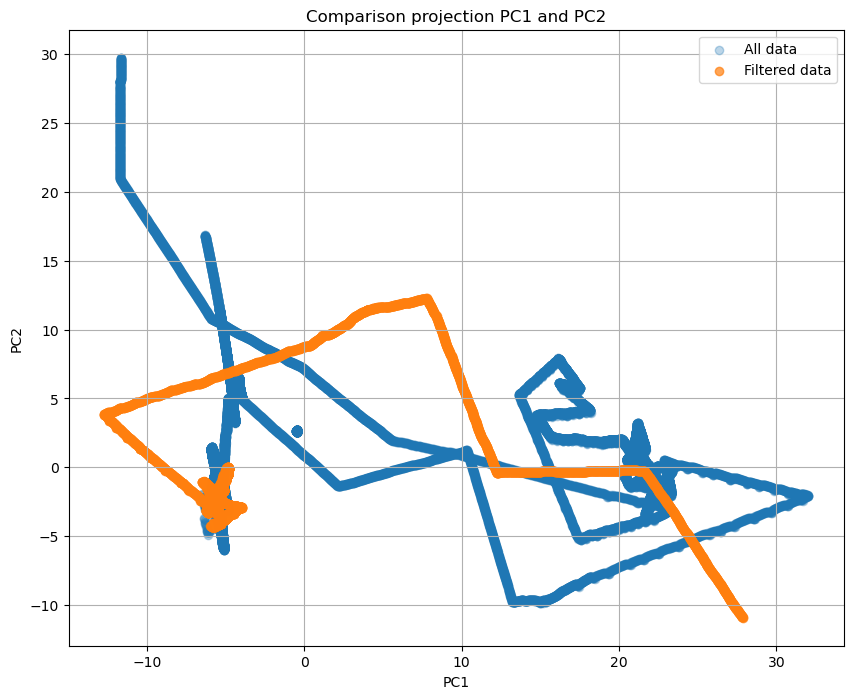

In [44]:
# Comparaison des projections
plt.figure(figsize=(10, 8))
plt.scatter(principal_components_all[:, 0], principal_components_all[:, 1], alpha=0.3, label='All data')
plt.scatter(principal_components_transition[:, 0], principal_components_transition[:, 1], alpha=0.7, label='Filtered data')
plt.title('Comparison projection PC1 and PC2')
plt.xlabel('PC1') 
plt.ylabel('PC2')
plt.legend()
plt.grid()
plt.show()


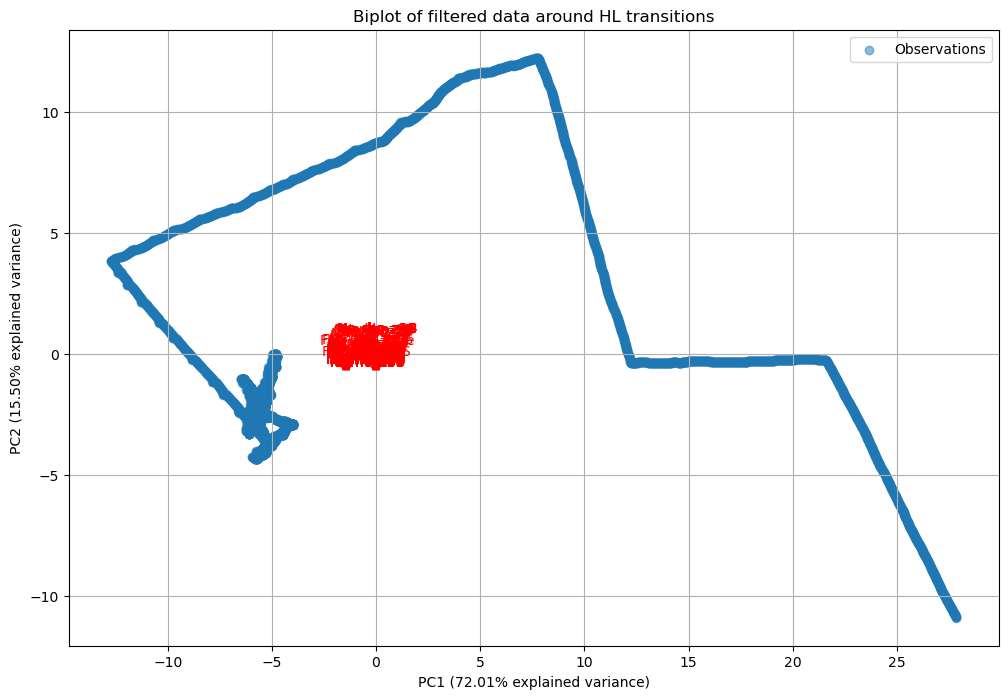

In [45]:
# Biplot for filtered data
#needs to be modified
plt.figure(figsize=(12, 8))
plt.scatter(principal_components_transition[:, 0], principal_components_transition[:, 1], alpha=0.5, label='Observations')

# Add vector to features
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings_transition.iloc[i, 0]*5, loadings_transition.iloc[i, 1]*5, color='red', alpha=0.5)
    plt.text(loadings_transition.iloc[i, 0]*5.2, loadings_transition.iloc[i, 1]*5.2, feature, color='red', ha='center', va='center')

plt.xlabel(f'PC1 ({pca_transition.explained_variance_ratio_[0]*100:.2f}% explained variance)')
plt.ylabel(f'PC2 ({pca_transition.explained_variance_ratio_[1]*100:.2f}% explained variance)')
plt.title('Biplot of filtered data around HL transitions')
plt.grid()
plt.legend()
plt.show()


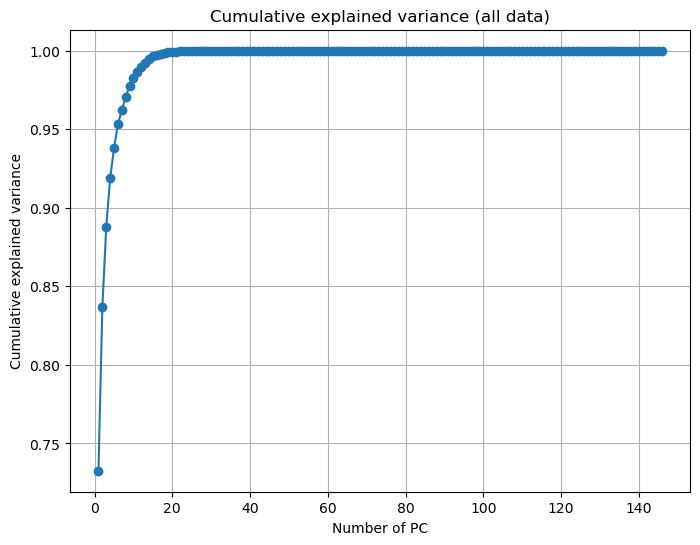

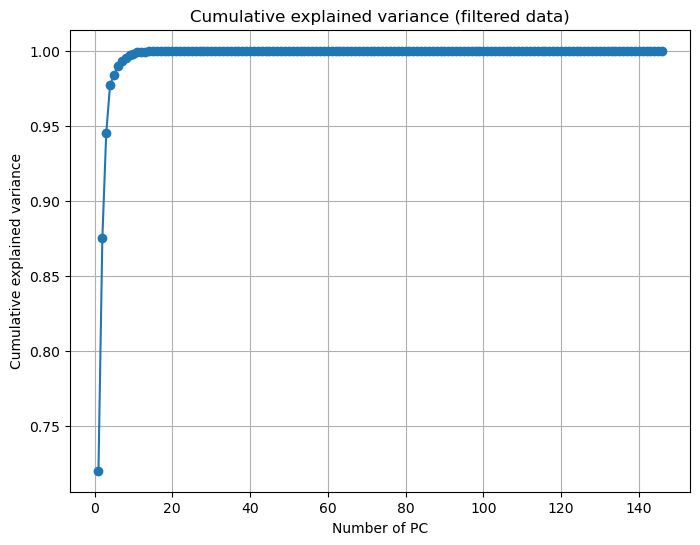

In [46]:
# Pour les données non filtrées
pca_full_all = PCA()
pca_full_all.fit(scaled_data_all)
explained_variance_ratio_all = pca_full_all.explained_variance_ratio_
cumulative_variance_all = np.cumsum(explained_variance_ratio_all)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_all)+1), cumulative_variance_all, marker='o')
plt.title('Cumulative explained variance (all data)')
plt.xlabel('Number of PC')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

# Pour les données filtrées
pca_full_transition = PCA()
pca_full_transition.fit(scaled_data_transition)
explained_variance_ratio_transition = pca_full_transition.explained_variance_ratio_
cumulative_variance_transition = np.cumsum(explained_variance_ratio_transition)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_transition)+1), cumulative_variance_transition, marker='o')
plt.title('Cumulative explained variance (filtered data)')
plt.xlabel('Number of PC')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

### Observations on the full dataset ###
- **PC1**: This component is primarily influenced by electron temperature measurements at higher radial positions (Te_rho_z40 to Te_rho_z47), indicating that variations in the outer plasma temperature are the dominant source of variation in the full dataset.
- **PC2**: This component is driven by electron density measurements at lower radial positions (Ne_rho_z3 to Ne_rho_z12), reflecting the importance of changes in the inner plasma density.
### Observations on filtered data ###
- **PC1**: For the HL transition data, the primary influence shifts to electron density measurements at higher radial positions (Ne_rho_z35 to Ne_rho_z44), suggesting that outer plasma density plays a crucial role during transitions.
- **PC2**: Here, electron temperature measurements at lower radial positions (Te_rho_z1 to Te_rho_z10) become more significant, indicating that inner plasma temperature is a major factor during transitions.

It is important to note that PCA describes the importance of each feature relative to the variance explained by the components. The features with the highest absolute loadings on the principal components are those that contribute most to the variance in the dataset. Therefore, the principal components do not directly indicate causal relationships but rather highlight which features contribute the most to the variation observed in the data.



## Selected experiments and conclusions  ##
All the explorations conducted in this notebook, including those related to the physics of the features and the structure of the dataset, led us to select two distinct combinations of experiments. The key difference between these two combinations lies in the inclusion of IPLA versus IP.


features1 = [
        'Wtot', 'DML', 'FIR_LIDs_core', 'FIR_LIDs_LFS', 'FIR_LIDs_HFS', 'IPLA',
        'Halpha13', 'Z_axis', 'POHM', 'Ne_rho_z35', 'Te_rho_z1', 'Te_rho_z2'
    ] + [f'Te_rho_{i}' for i in range(1, 68)] + [f'Ne_rho_{i}' for i in range(1, 68)]

features2 = [
        'Wtot', 'DML', 'FIR_LIDs_core', 'FIR_LIDs_LFS', 'FIR_LIDs_HFS', 'IP',
        'Halpha13', 'Z_axis', 'POHM', 'Ne_rho_z35', 'Te_rho_z1', 'Te_rho_z2'
    ] + [f'Te_rho_{i}' for i in range(1, 68)] + [f'Ne_rho_{i}' for i in range(1, 68)]

As only 35 experiments out of 297 were lacking a large amount of these features we decided to exclude them from the data to preprocess.


### Create folders for selected and exluded experiments ###
To operate our code we then divided the experiments between selected and excluded.
We excluded the 35 experiments lacking a large number fo features necessary for our models (0,1,2,3) and combination 7 who is lacking feature DML, also necessary for our models.
In the future experiments lacking a small number of features could be used with our model using imputation to fill the missing features leveraging data from the rest of the dataset. 

The code in the cells below has an interest only if you have access to data and you want to divide the experiments in usable data (selected_experiments) and non-usable (excluded_experimets) for our models.

In [50]:

import shutil

# Paths
source_folder = '3_4_LH_HL_data'
excluded_folder = 'excluded_experiments'
selected_folder = 'selected_experiments'


os.makedirs(excluded_folder, exist_ok=False)
os.makedirs(selected_folder, exist_ok=False)

# Selected feature combinations to exclude
excluded_combinations_indexes = {0, 1, 2, 3, 7}
excluded_shots = set()

# Iterate through sorted combinations and collect experiments to exclude
for i, (features, list_experiments) in enumerate(sorted_combinations):
    if i in excluded_combinations_indexes:
        excluded_shots.update(list_experiments)

# Move files to appropriate folders
for file in os.listdir(source_folder):
    file_path = os.path.join(source_folder, file)
    # Extract shot number from file name
    match = re.search(r"TCV_DATAno(\d{5})build\.parquet", file)
    if match:
        shot_number = int(match.group(1))
        if shot_number in excluded_shots:
            shutil.move(file_path, os.path.join(excluded_folder, file))
        else:
            shutil.move(file_path, os.path.join(selected_folder, file))

# Load HL_times.json and create HL_times_sel.json
with open('HL_times.json', 'r') as f:
    HL_times = json.load(f)

HL_times = {int(k): v for k, v in HL_times.items()}  # Convert keys to integers
HL_times_sel = {k: v for k, v in HL_times.items() if k not in excluded_shots}

# Save the new HL_times_sel.json
with open('HL_times_sel.json', 'w') as f:
    json.dump(HL_times_sel, f, indent=4)

print("Files for excluded experiments moved to:", excluded_folder)
print("Files for selected experiments moved to:", selected_folder)
print("New HL_times_sel.json created.")


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'excluded_experiments'

In [ ]:
# Count files in each folder
excluded_files_count = len([file for file in os.listdir(excluded_folder) if os.path.isfile(os.path.join(excluded_folder, file))])
selected_files_count = len([file for file in os.listdir(selected_folder) if os.path.isfile(os.path.join(selected_folder, file))])

# Print the counts
print(f"Number of files in '{excluded_folder}': {excluded_files_count}")
print(f"Number of files in '{selected_folder}': {selected_files_count}")
